# This a jupyter notebook guide on domain analysis

by Pu Zheng and Bogdan Bintu

2020.06.06



## Import packages

In [2]:
# imports
import sys, os, glob, time, copy
import numpy as np
import scipy
import pickle

sys.path.append(os.path.abspath(r"..\."))

import source as ia

from scipy.signal import find_peaks
from scipy.spatial.distance import cdist,pdist,squareform

print(os.getpid())

46592


## Import plotting

In [3]:
# Required plotting setting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
_font_size = 7.5

In [4]:
# Required plotting parameters
from source.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size

In [5]:
# figure folder
parent_figure_folder = r'\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\final_figures'
figure_folder = os.path.join(parent_figure_folder, 'Chr21_domain_figures')
print(figure_folder)
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)
    print("generating this folder")

\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\final_figures\Chr21_domain_figures


# 0. Load data

In [6]:
data_folder = r'E:\Users\puzheng\Dropbox\2020 Chromatin Imaging Manuscript\Revision\DataForReviewers'
rep1_filename = os.path.join(data_folder, 'chromosome21.tsv')
rep2_filename = os.path.join(data_folder, 'chromosome21-cell_cycle.tsv')

## 0.1 load replicate 1

In [7]:
# load from file and extract info
import csv
rep1_info_dict = {}
with open(rep1_filename, 'r') as _handle:
    _reader = csv.reader(_handle, delimiter='\t', quotechar='|')
    _headers = next(_reader)
    print(_headers)
    # create keys for each header
    for _h in _headers:
        rep1_info_dict[_h] = []
    # loop through content
    for _contents in _reader:
        for _h, _info in zip(_headers,_contents):
            rep1_info_dict[_h].append(_info)

['Z(nm)', 'X(nm)', 'Y(nm)', 'Genomic coordinate', 'Chromosome copy number', 'Gene names', 'Transcription', 'TSS ZXY(nm)']


In [8]:
from tqdm import tqdm_notebook as tqdm

# clean up infoa
data_rep1 = {'params':{}}

# clean up genomic coordiantes
region_names = np.array([_n for _n in sorted(region_names, key=lambda s:int(s.split(':')[1].split('-')[0]))])
region_starts = np.array([int(_n.split(':')[1].split('-')[0]) for _n in region_names])
region_ends = np.array([int(_n.split(':')[1].split('-')[1]) for _n in region_names])[np.argsort(region_starts)]
region_starts = np.sort(region_starts)

mid_positions = ((region_starts + region_ends)/2).astype(np.int)
mid_positions_Mb = np.round(mid_positions / 1e6, 2) 

# clean up chrom copy number
chr_nums = np.array([int(_info) for _info in rep1_info_dict['Chromosome copy number']])
chr_ids, region_cts = np.unique(chr_nums, return_counts=True)
dna_zxys_list = [[[] for _start in region_starts] for _id in chr_ids]

# clean up zxy
for _z,_x,_y,_reg_info, _cid in tqdm(zip(rep1_info_dict['Z(nm)'],rep1_info_dict['X(nm)'],\
                                         rep1_info_dict['Y(nm)'],rep1_info_dict['Genomic coordinate'],\
                                         rep1_info_dict['Chromosome copy number'])):
    # get chromosome inds
    _cid = int(_cid)
    _cind = np.where(chr_ids == _cid)[0][0]
    
    # get region indices
    _start = int(_reg_info.split(':')[1].split('-')[0])
    _rind = np.where(region_starts==_start)[0][0]
    
    dna_zxys_list[_cind][_rind] = np.array([float(_z),float(_x), float(_y)])

# merge together
dna_zxys_list = np.array(dna_zxys_list)
data_rep1['chrom_ids'] = chr_ids
data_rep1['region_names'] = region_names
data_rep1['mid_position_Mb'] = mid_positions_Mb
data_rep1['dna_zxys'] = dna_zxys_list

# clean up tss and transcription
if 'Gene names' in rep1_info_dict:
    import re
    # first extract number of genes
    gene_names = []
    for _gene_info, _trans_info, _tss_coord in zip(rep1_info_dict['Gene names'],
                                                   rep1_info_dict['Transcription'],
                                                   rep1_info_dict['TSS ZXY(nm)']):
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            for _gene in _genes:
                if _gene not in gene_names:
                    gene_names.append(_gene)
    print(f"{len(gene_names)} genes exist in this dataset.")
    
    # initialize gene and transcription
    tss_zxys_list = [[[] for _gene in gene_names] for _id in chr_ids]
    transcription_profiles = [[[] for _gene in gene_names] for _id in chr_ids]
    # loop through to get info
    for _cid, _gene_info, _trans_info, _tss_locations in tqdm(zip(rep1_info_dict['Chromosome copy number'],
                                                                  rep1_info_dict['Gene names'],
                                                                  rep1_info_dict['Transcription'],
                                                                  rep1_info_dict['TSS ZXY(nm)'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        # process if there are genes in this region:
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            _transcribes = _trans_info.split(';')[:-1]
            _tss_zxys = _tss_locations.split(';')[:-1]
            for _gene, _transcribe, _tss_zxy in zip(_genes, _transcribes, _tss_zxys):
                # get gene index
                _gind = gene_names.index(_gene)
                # get transcription profile
                if _transcribe == 'on':
                    transcription_profiles[_cind][_gind] = True
                else:
                    transcription_profiles[_cind][_gind] = False
                # get coordinates
                _tss_zxy = np.array([np.float(_c) for _c in re.split(r'\s+', _tss_zxy.split('[')[1].split(']')[0]) if _c != ''])
                tss_zxys_list[_cind][_gind] = _tss_zxy
                
    tss_zxys_list = np.array(tss_zxys_list)
    transcription_profiles = np.array(transcription_profiles)
    data_rep1['gene_names'] = gene_names
    data_rep1['tss_zxys'] = tss_zxys_list
    data_rep1['trans_pfs'] = transcription_profiles

# clean up cell_cycle states
if 'Cell cycle state' in rep1_info_dict:
    cell_cycle_types = np.unique(rep1_info_dict['Cell cycle state'])
    cell_cycle_flag_dict = {_k:[[] for _id in chr_ids] for _k in cell_cycle_types if _k != 'ND'}
    for _cid, _state in tqdm(zip(rep1_info_dict['Chromosome copy number'],rep1_info_dict['Cell cycle state'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        if np.array([_v[_cind]==[] for _k,_v in cell_cycle_flag_dict.items()]).any():
            for _k,_v in cell_cycle_flag_dict.items():
                if _k == _state:
                    _v[_cind] = True
                else:
                    _v[_cind] = False
    # append to data
    for _k, _v in cell_cycle_flag_dict.items():
        data_rep1[f'{_k}_flags'] = np.array(_v)  


84 genes exist in this dataset.


dict_keys(['params', 'chrom_ids', 'mid_position_Mb', 'dna_zxys', 'gene_names', 'tss_zxys', 'trans_pfs'])

# 1. population averaged description of chr21

## 1.1 (FigS1F) population average maps:

median distance map, proximity frequency map, corresponding Hi-C map

In [14]:
zxys_rep1_list = np.array(data_rep1['dna_zxys'])
distmap_rep1_list = np.array([squareform(pdist(_zxy)) for _zxy in zxys_rep1_list])

# generate median distance map
median_distance_map_rep1 = np.nanmedian(distmap_rep1_list, axis = 0)
# generate contact map
contact_th = 500
contact_map_rep1 = np.nanmean(distmap_rep1_list < contact_th, axis=0)
# load Hi-C
with np.load(r'\\10.245.74.158\Chromatin_NAS_0\Hi-C\5x10_distmap.npz') as handle:
    hic_raw_map = handle['distance_map']

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


In [15]:
from matplotlib.colors import LogNorm

median_limits = [0, 2000]
median_cmap = matplotlib.cm.get_cmap('seismic_r')
median_cmap.set_bad(color=[0.,0.,0.,1])

contact_limits = [0.05, 0.6]
contact_norm = LogNorm(vmin=np.min(contact_limits), 
                       vmax=np.max(contact_limits))
contact_cmap = matplotlib.cm.get_cmap('seismic')
contact_cmap.set_bad(color=[0.,0.,0.,1])

hic_limits = [1, 400]
hic_norm = LogNorm(vmin=np.min(hic_limits), 
                   vmax=np.max(hic_limits))
hic_cmap = matplotlib.cm.get_cmap('seismic')
hic_cmap.set_bad(color=[0.,0.,0.,1])

\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\final_figures\Chr21_domain_figures


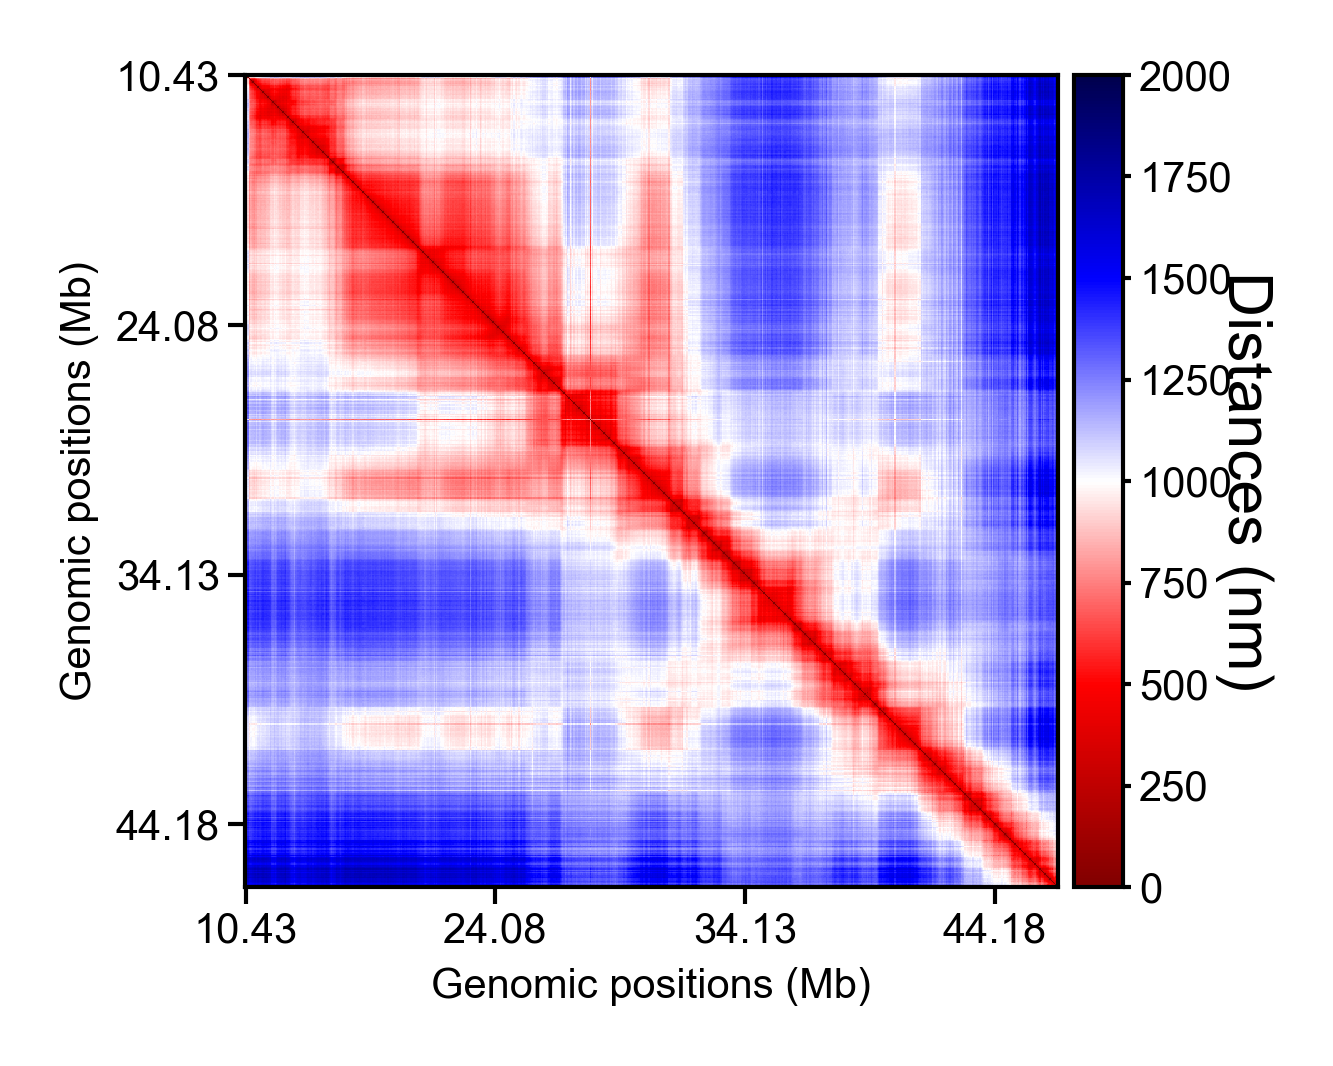

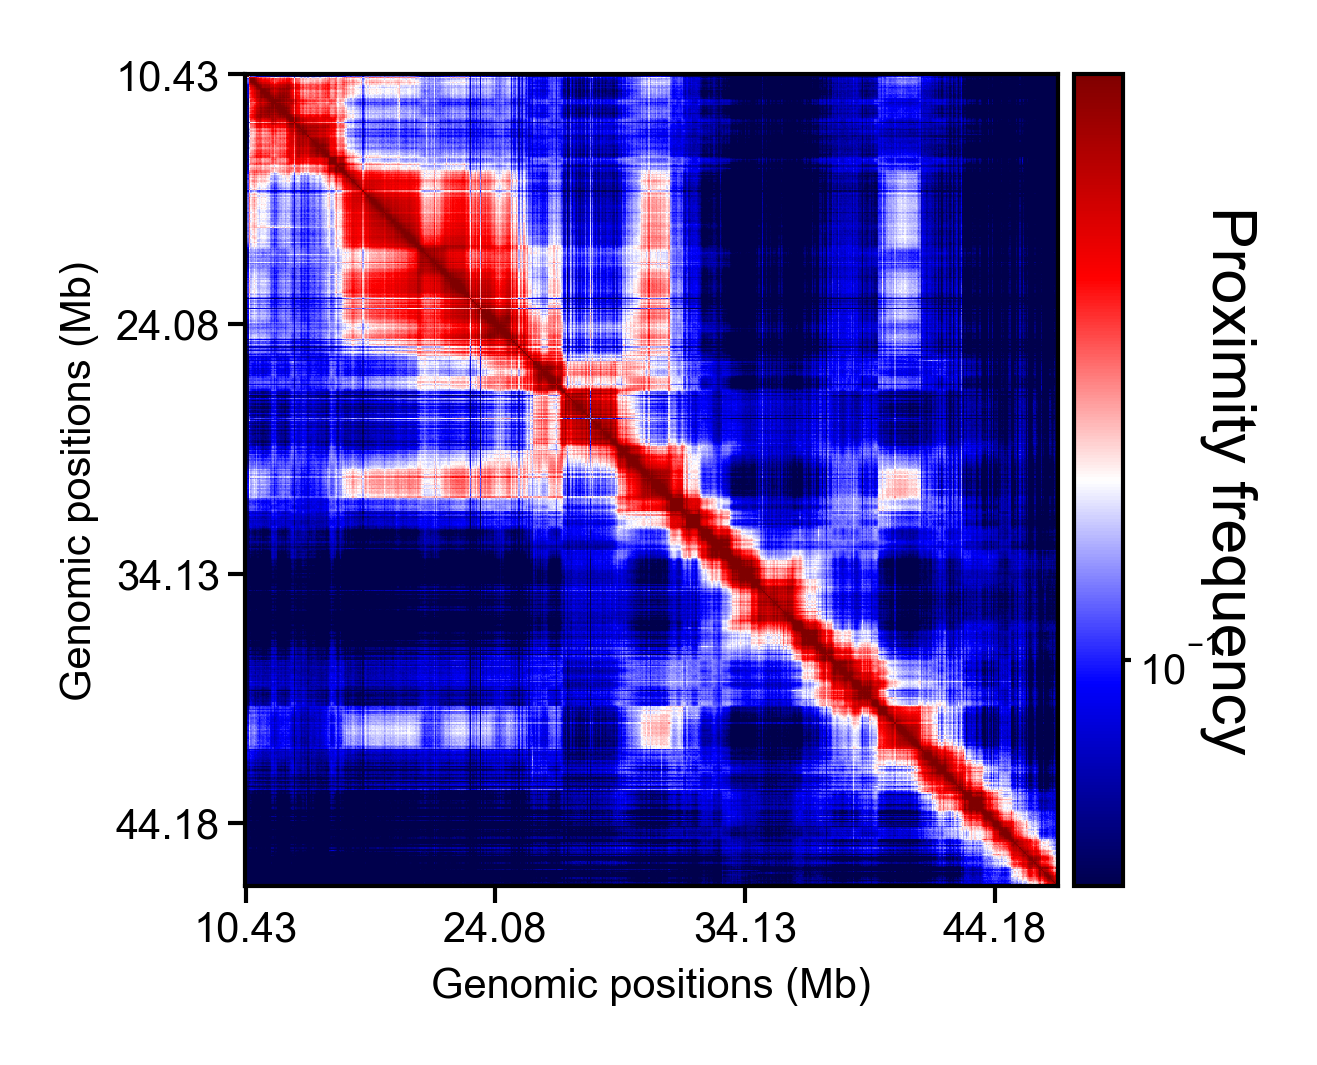

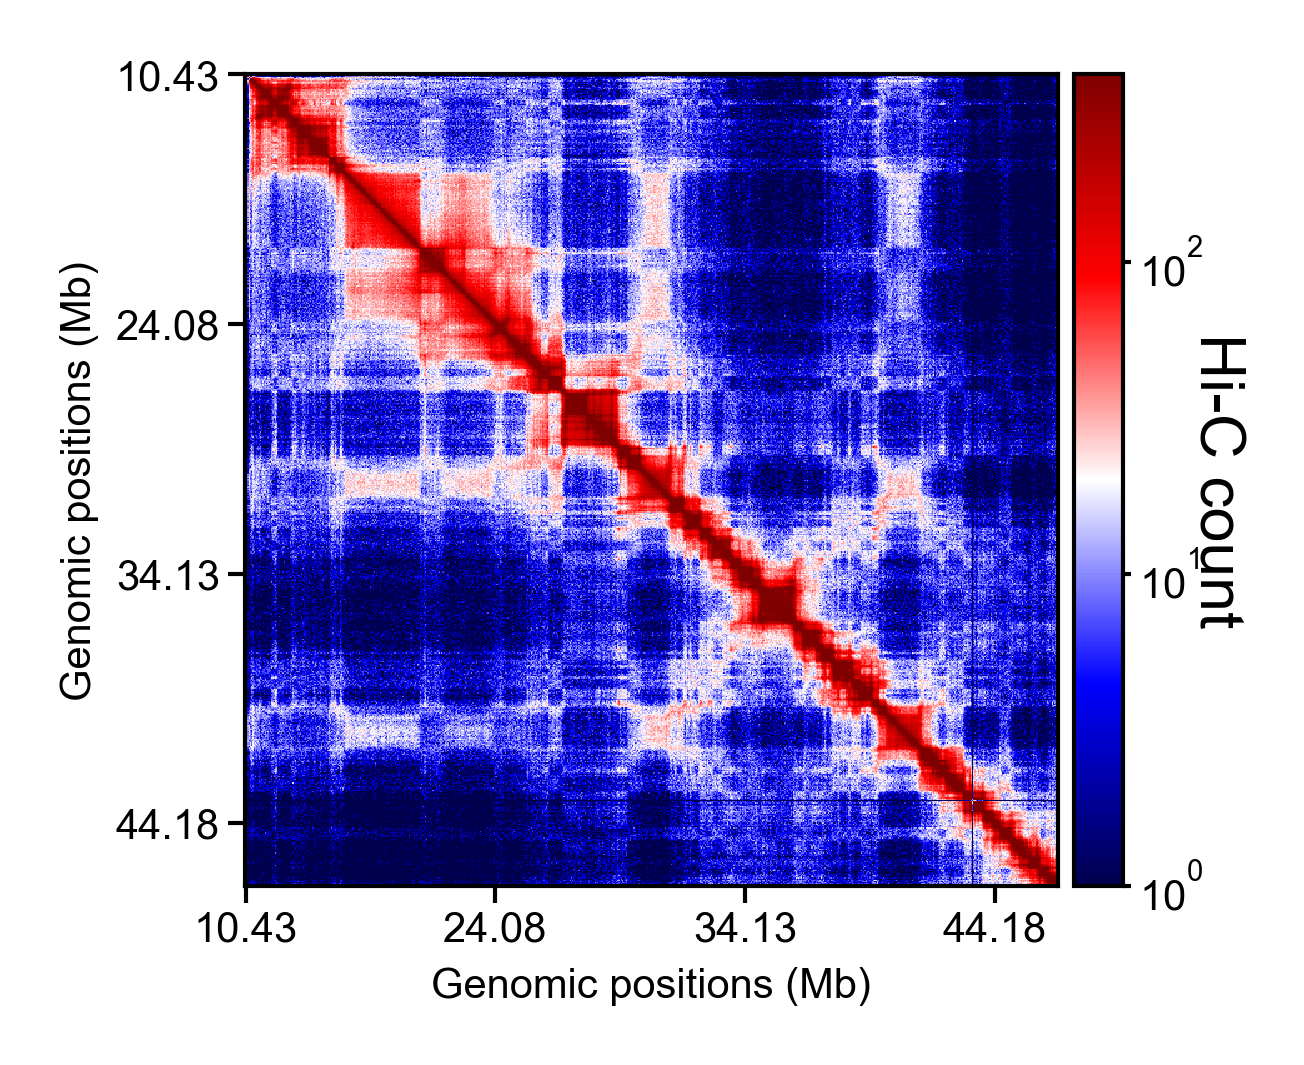

In [16]:
from source.figure_tools.distmap import plot_distance_map
print(figure_folder)
%matplotlib inline
distmap_ax = plot_distance_map(median_distance_map_rep1, 
                               cmap=median_cmap,
                               color_limits=median_limits,
                               tick_labels=mid_positions_Mb, 
                               ax_label='Genomic positions (Mb)', 
                               colorbar_labels='Distances (nm)',
                               save=True, save_folder=figure_folder, 
                               save_basename=f'FigS1F1_median_distmap_rep1.pdf',
                               font_size=5)
contact_ax = plot_distance_map(contact_map_rep1, 
                               cmap=contact_cmap,
                               color_limits=contact_limits,
                               color_norm=contact_norm,
                               tick_labels=mid_positions_Mb, 
                               ax_label='Genomic positions (Mb)', 
                               colorbar_labels='Proximity frequency',
                               save=True, save_folder=figure_folder, 
                               save_basename=f'FigS1F2_contact_map_rep1.pdf',
                               font_size=5)
hic_ax = plot_distance_map(hic_raw_map, 
                               cmap=hic_cmap,
                               color_limits=hic_limits,
                               color_norm=hic_norm,
                               tick_labels=mid_positions_Mb, 
                               ax_label='Genomic positions (Mb)', 
                               colorbar_labels='Hi-C count',
                               save=True, save_folder=figure_folder, 
                               save_basename=f'FigS1F3_hic_map.pdf',
                               font_size=5)

## 1.2 (S1G) correlation between median-distance vs. Hi-C

In [17]:
good_spot_flags = np.isnan(np.array(zxys_rep1_list)).sum(2)==0

failure_rates = 1 - np.mean(good_spot_flags, axis=0)

good_regions_rep1 = np.where(failure_rates < 0.25)[0]
print(len(good_regions_rep1))

kept_median_rep1 = median_distance_map_rep1[good_regions_rep1][:,good_regions_rep1]
kept_hic_rep1 = hic_raw_map[good_regions_rep1][:,good_regions_rep1]

wt_median_entries_rep1 = kept_median_rep1[np.triu_indices(len(kept_median_rep1),1)]
hic_contact_entries_rep1 = kept_hic_rep1[np.triu_indices(len(kept_hic_rep1),1)]

kept = (wt_median_entries_rep1>0) * (hic_contact_entries_rep1>0)

from scipy.stats import linregress, pearsonr
lr_rep1 = linregress(np.log(wt_median_entries_rep1[kept]),
                np.log(hic_contact_entries_rep1[kept]))
print(lr_rep1)
print('pearson correlation:', np.abs(lr_rep1.rvalue))

639
LinregressResult(slope=-4.428953144759954, intercept=32.59182922330042, rvalue=-0.8918216634748625, pvalue=0.0, stderr=0.005232118687051619)
pearson correlation: 0.8918216634748625


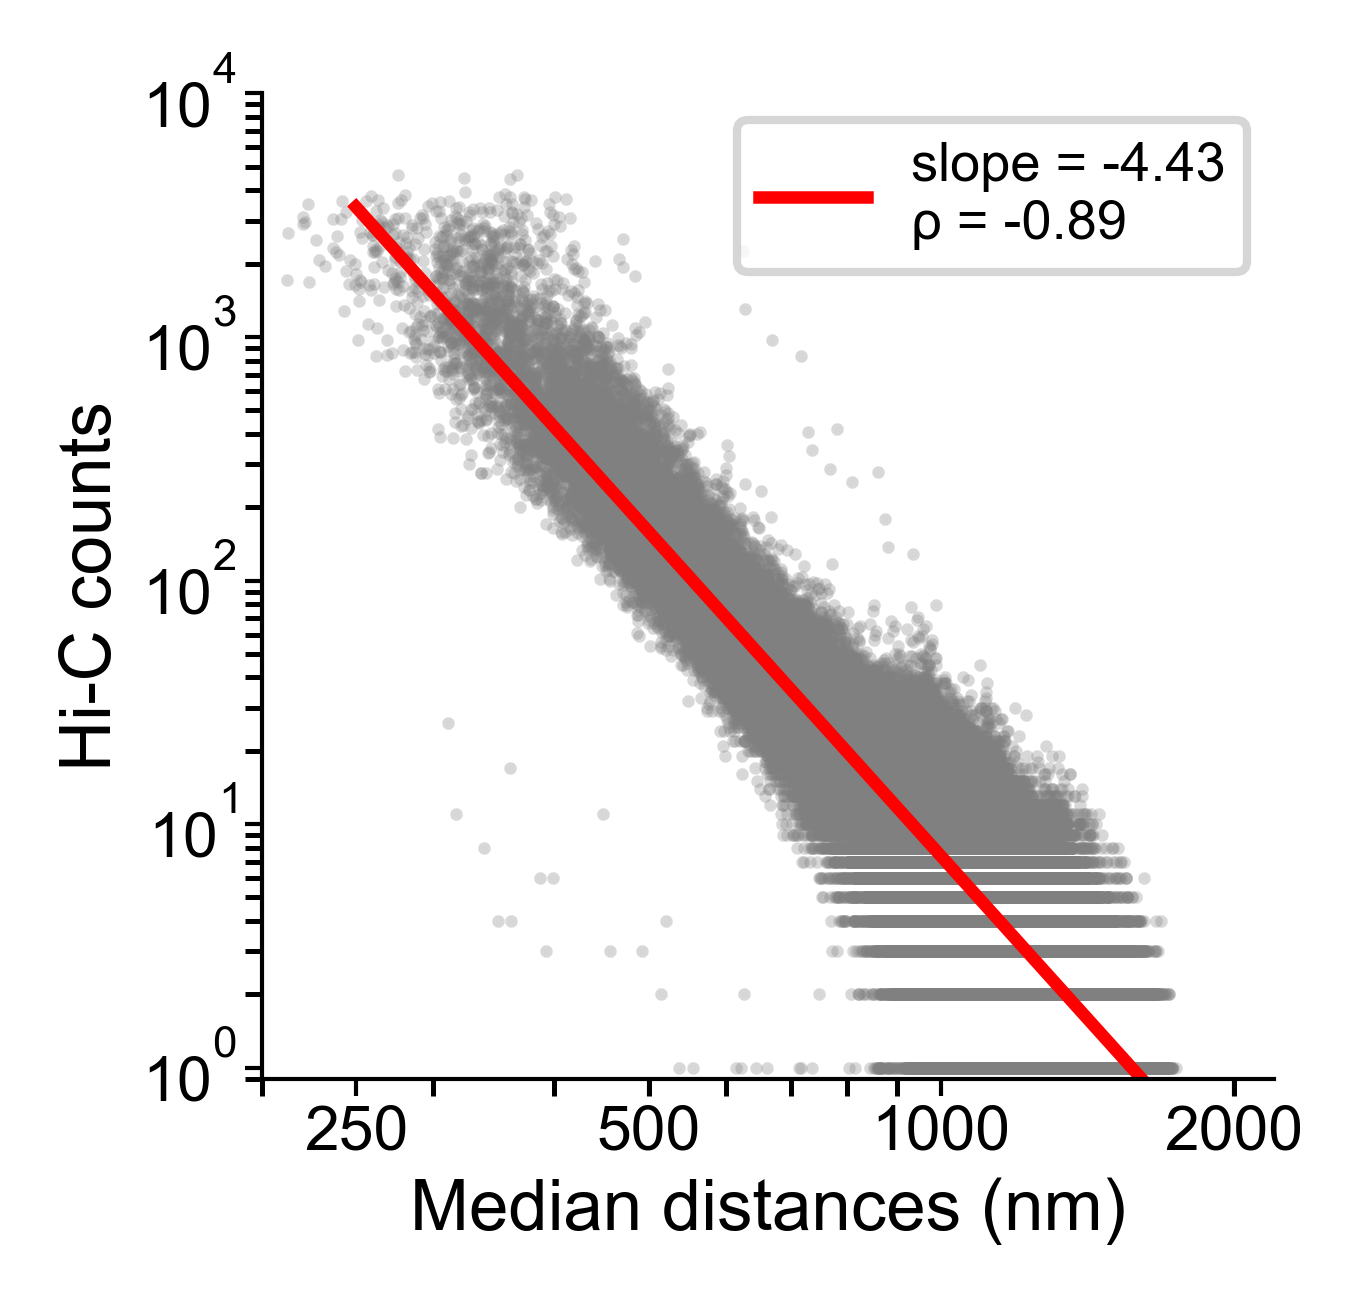

In [18]:
xticks = np.round(2**np.linspace(-2,1,4)*1000,0).astype(np.int)
yticks = np.logspace(0, 4, 3).astype(np.int)
xlim = [200,2200]
# draw scatter plot
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=_dpi)
ax.plot(wt_median_entries_rep1[kept], hic_contact_entries_rep1[kept], '.', color='gray', alpha=0.3, markersize=1, )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(xticks, minor=False)
ax.set_xticklabels(xticks)

ax.tick_params('both', labelsize=_font_size, 
               width=_ticklabel_width, length=_ticklabel_size,
               pad=1)
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Median distances (nm)', labelpad=2, fontsize=_font_size+1)
ax.set_ylabel('Hi-C counts', labelpad=2, fontsize=_font_size+1)

ax.set_xlim(xlim)
ax.set_ylim([0.9,10000])

#ax.set_yticks(yticks, minor=True)
#ax.set_yticklabels(yticks)


reg_x = np.linspace(250, 2000, 100)
reg_y = np.exp( lr_rep1.slope * np.log(reg_x) + lr_rep1.intercept)

ax.plot(reg_x, reg_y, 'r', label=f'slope = {lr_rep1.slope:.2f}\n\u03C1 = {lr_rep1.rvalue:.2f}')

plt.legend(loc='upper right', fontsize=_font_size-1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)

plt.savefig(os.path.join(figure_folder, 'FigS1G_scatter_median_hic_rep1.pdf'), transparent=True)

plt.show()

## Zoomed in correlation

In [19]:
limits = [325, 390]
crop = slice(limits[0],limits[1])

LinregressResult(slope=-4.510639545000579, intercept=33.01273591541818, rvalue=-0.9657300345700288, pvalue=0.0, stderr=0.02661930905717792)
pearson correlation: 0.9657300345700288


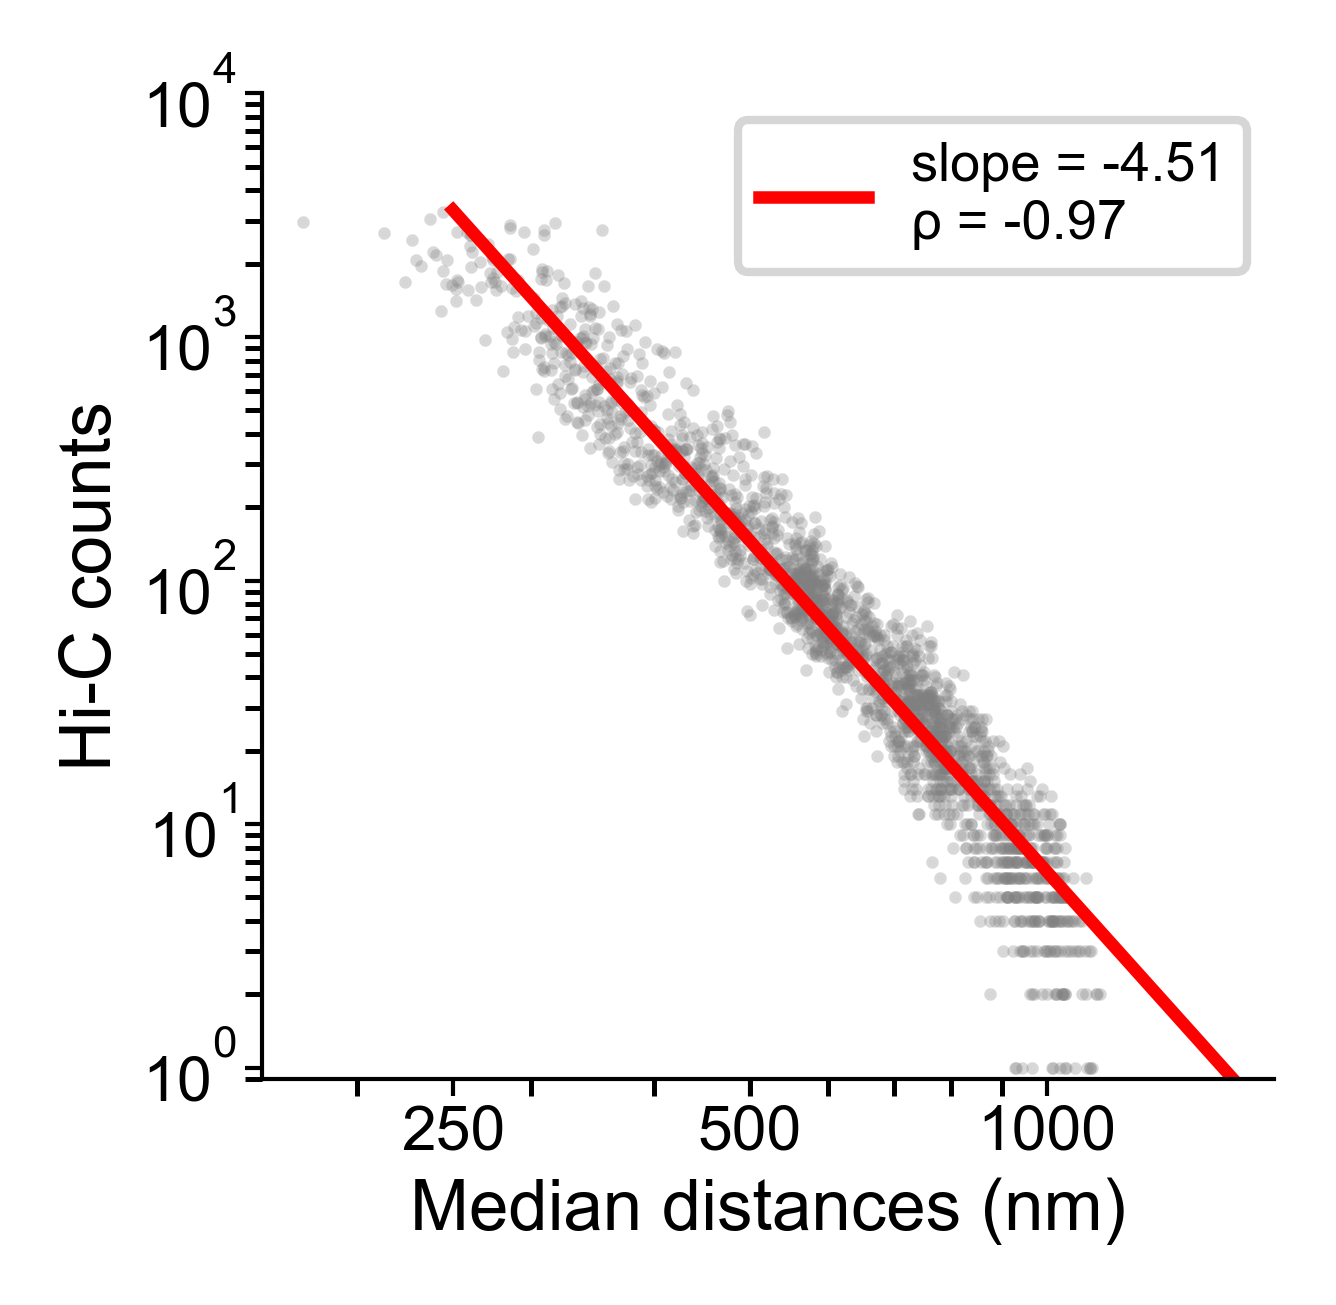

In [24]:
good_crop_regions_rep1 = np.array([_r for _r in good_regions_rep1 if _r in np.arange(limits[0], limits[1])], dtype=np.int)

kept_crop_median_rep1 = median_distance_map_rep1[good_crop_regions_rep1][:,good_crop_regions_rep1]
kept_crop_hic_rep1 = hic_raw_map[good_crop_regions_rep1][:,good_crop_regions_rep1]

wt_crop_median_entries_rep1 = kept_crop_median_rep1[np.triu_indices(len(kept_crop_median_rep1),1)]
hic_crop_contact_entries_rep1 = kept_crop_hic_rep1[np.triu_indices(len(kept_crop_hic_rep1),1)]

kept_crop_rep1 = (wt_crop_median_entries_rep1>0) * (hic_crop_contact_entries_rep1>0)

from scipy.stats import linregress, pearsonr
lr_crop_rep1 = linregress(np.log(wt_crop_median_entries_rep1[kept_crop_rep1]),
                np.log(hic_crop_contact_entries_rep1[kept_crop_rep1]))
print(lr_crop_rep1)
print('pearson correlation:', np.abs(lr_crop_rep1.rvalue))

# Plot
xticks = np.round(2**np.linspace(-2,1,4)*1000,0).astype(np.int)
yticks = np.logspace(0, 4, 3).astype(np.int)
xlim = [160,1700]
# draw scatter plot
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=_dpi)
ax.plot(wt_crop_median_entries_rep1[kept_crop_rep1], 
        hic_crop_contact_entries_rep1[kept_crop_rep1], '.', color='gray', alpha=0.3, markersize=1, )
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(xticks, minor=False)
ax.set_xticklabels(xticks)

ax.tick_params('both', labelsize=_font_size, 
               width=_ticklabel_width, length=_ticklabel_size,
               pad=1)
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel('Median distances (nm)', labelpad=2, fontsize=_font_size+1)
ax.set_ylabel('Hi-C counts', labelpad=2, fontsize=_font_size+1)

reg_x = np.linspace(250, 2000, 100)
reg_y = np.exp( lr_crop_rep1.slope * np.log(reg_x) + lr_crop_rep1.intercept)

ax.set_xlim(xlim)
ax.set_ylim([0.9,10000])

ax.plot(reg_x, reg_y, 'r', label=f'slope = {lr_crop_rep1.slope:.2f}\n\u03C1 = {lr_crop_rep1.rvalue:.2f}')

plt.legend(loc='upper right', fontsize=_font_size-1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)

plt.savefig(os.path.join(figure_folder, f'FigS1I_scatter_median_hic_{limits}.pdf'), transparent=True)

plt.show()

## Determine best correlation bewteen contact and Hi-C

100


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


200
300
400
500
600
700
800
900
1000
100 nm; pearson correlation: 0.7386207901977095
200 nm; pearson correlation: 0.845935834972241
300 nm; pearson correlation: 0.8710040155266386
400 nm; pearson correlation: 0.8788059625254343
500 nm; pearson correlation: 0.8783083356439234
600 nm; pearson correlation: 0.872082577654535
700 nm; pearson correlation: 0.862050715834203
800 nm; pearson correlation: 0.8491518489432908
900 nm; pearson correlation: 0.8340068568575382
1000 nm; pearson correlation: 0.8170037153975896


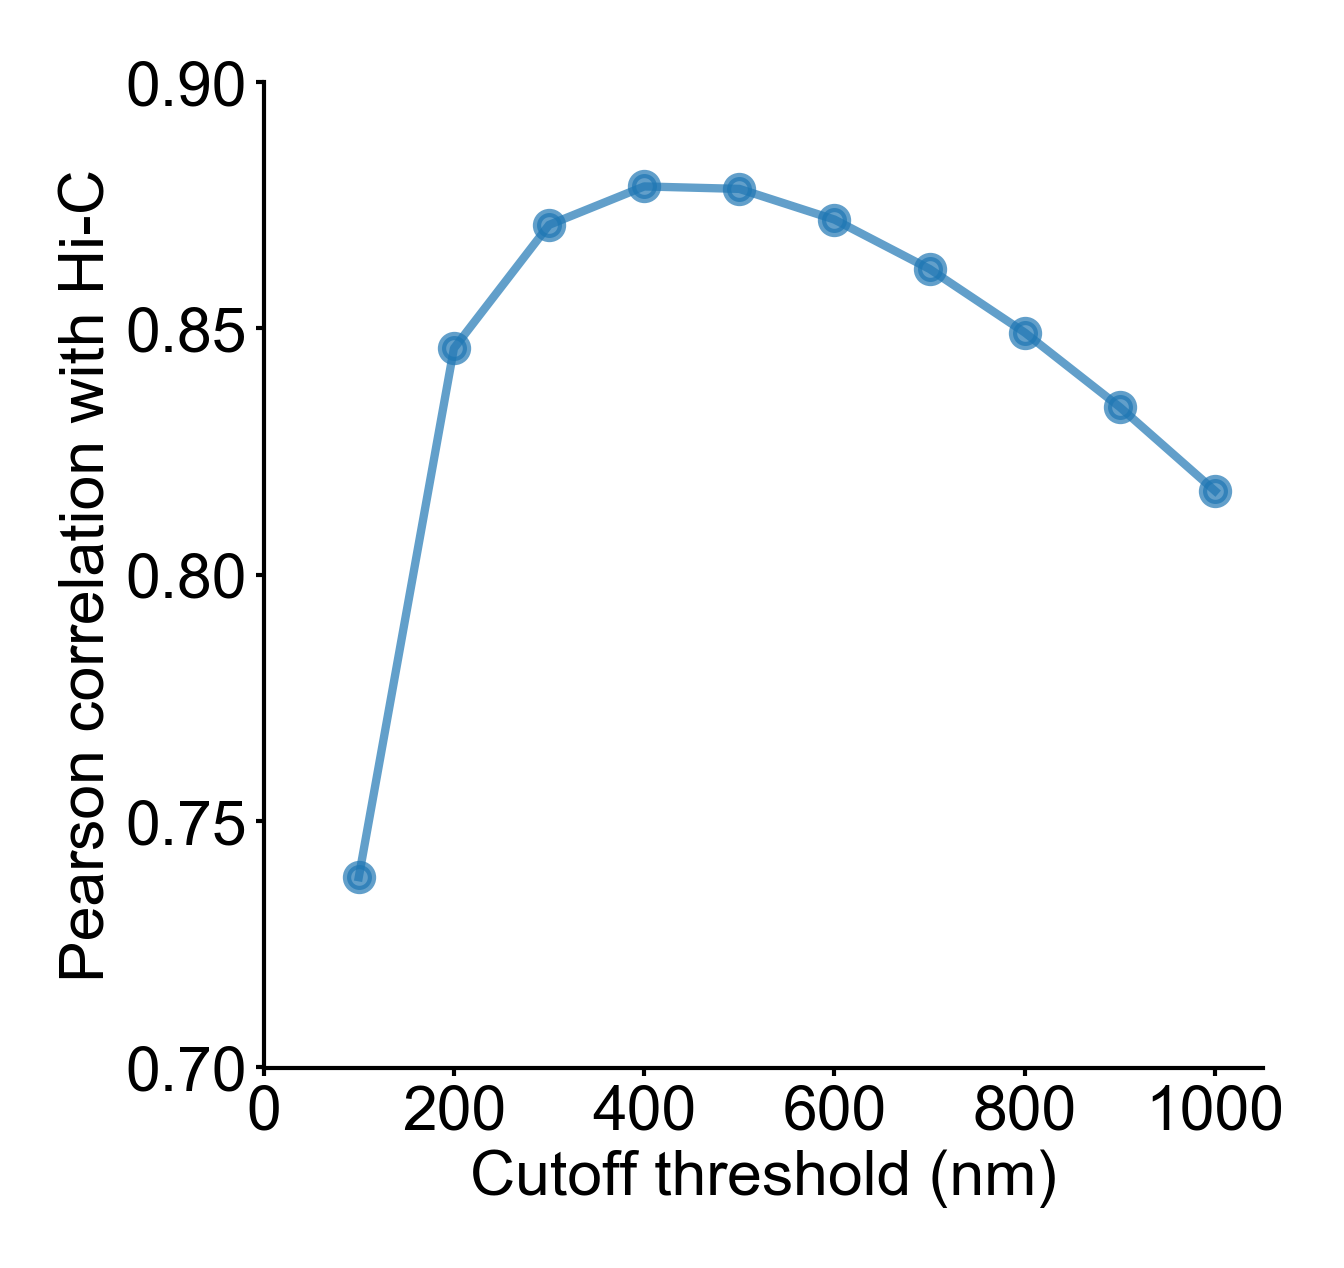

In [21]:
# generate contact maps
contact_map_dict_rep1 = {}
thr_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

for _thr in thr_list:
    print(_thr)
    contact_map_dict_rep1[_thr] = np.nanmean(distmap_rep1_list < _thr, axis=0)

# calculate pearson correlation with Hi-C
pearson_corr_list_rep1 = []
for _thr in thr_list:
    _contact_map = contact_map_dict_rep1[_thr]
    good_spot_flags = np.isnan(np.array(zxys_rep1_list)).sum(2)==0

    failure_rates = 1 - np.mean(good_spot_flags, axis=0)

    good_regions = np.where(failure_rates < 0.25)[0]
    #print(len(good_regions))

    kept_contacts = _contact_map[good_regions][:,good_regions]
    kept_hic = hic_raw_map[good_regions][:,good_regions]

    wt_contact_entries = kept_contacts[np.triu_indices(len(kept_contacts),1)]
    hic_contact_entries = kept_hic[np.triu_indices(len(kept_hic),1)]

    kept = (wt_contact_entries>0) * (hic_contact_entries>0)

    from scipy.stats import linregress, pearsonr
    lr = linregress(np.log(wt_contact_entries[kept]),
                    np.log(hic_contact_entries[kept]))
    print(_thr, 'nm; pearson correlation:', np.abs(lr.rvalue))
    
    pearson_corr_list_rep1.append(lr.rvalue)
    

%matplotlib inline
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)
ax.plot(thr_list, pearson_corr_list_rep1, linewidth=1, alpha=0.7, marker ='.')

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim([0.725,0.9])
ax.set_xlim([0,1050])
ax.set_xticks(np.arange(0,1001,200))
ax.set_yticks(np.arange(0.7,0.91,0.05))

ax.set_xlabel("Cutoff threshold (nm)", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Pearson correlation with Hi-C", fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.16)

plt.savefig(os.path.join(figure_folder, f'FigS1J_chr21_proximity_hic_pearson_with_thresholds_rep1.pdf'), transparent=True)

plt.show()

# 2. Analysis for single-cell domains

## 2.1 prepare data domains and compartments

In [9]:
import source.domain_tools.DomainAnalysis as da
import multiprocessing as mp

num_threads=32
domain_corr_cutoff = 0.75 
domain_dist_cutoff = 500 # nm

_domain_args = [(_zxys, 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _zxys in data_rep1['dna_zxys']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
if 'domain_starts' not in data_rep1:
    with mp.Pool(num_threads) as domain_pool:
        domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
        domain_pool.close()
        domain_pool.join()
        domain_pool.terminate()
    # save
    data_rep1['domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
    data_rep1['params']['domain_corr_cutoff'] = domain_corr_cutoff
    data_rep1['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts in 97.694s.


## 2.2 Genomic size and radius of gyration

In [13]:
from tqdm import tqdm_notebook as tqdm
def rg_mean(zxy):
    """computes radius of gyration"""
    zxy_ = np.array(zxy)
    zxy_ = zxy_[~np.isnan(zxy_[:,0])]
    zxy_ = zxy_ - np.median(zxy_,0)
    return np.mean(np.linalg.norm(zxy_,axis=-1))
rgs = []

zxys = data_rep1['dna_zxys']
dom_starts_fs = data_rep1['domain_starts']
for pt_,doms_ in tqdm(zip(zxys,dom_starts_fs)):
    for i1,i2 in zip(doms_[1:-2],doms_[2:-1]):
        rgs.append(rg_mean(pt_[i1:i2]))

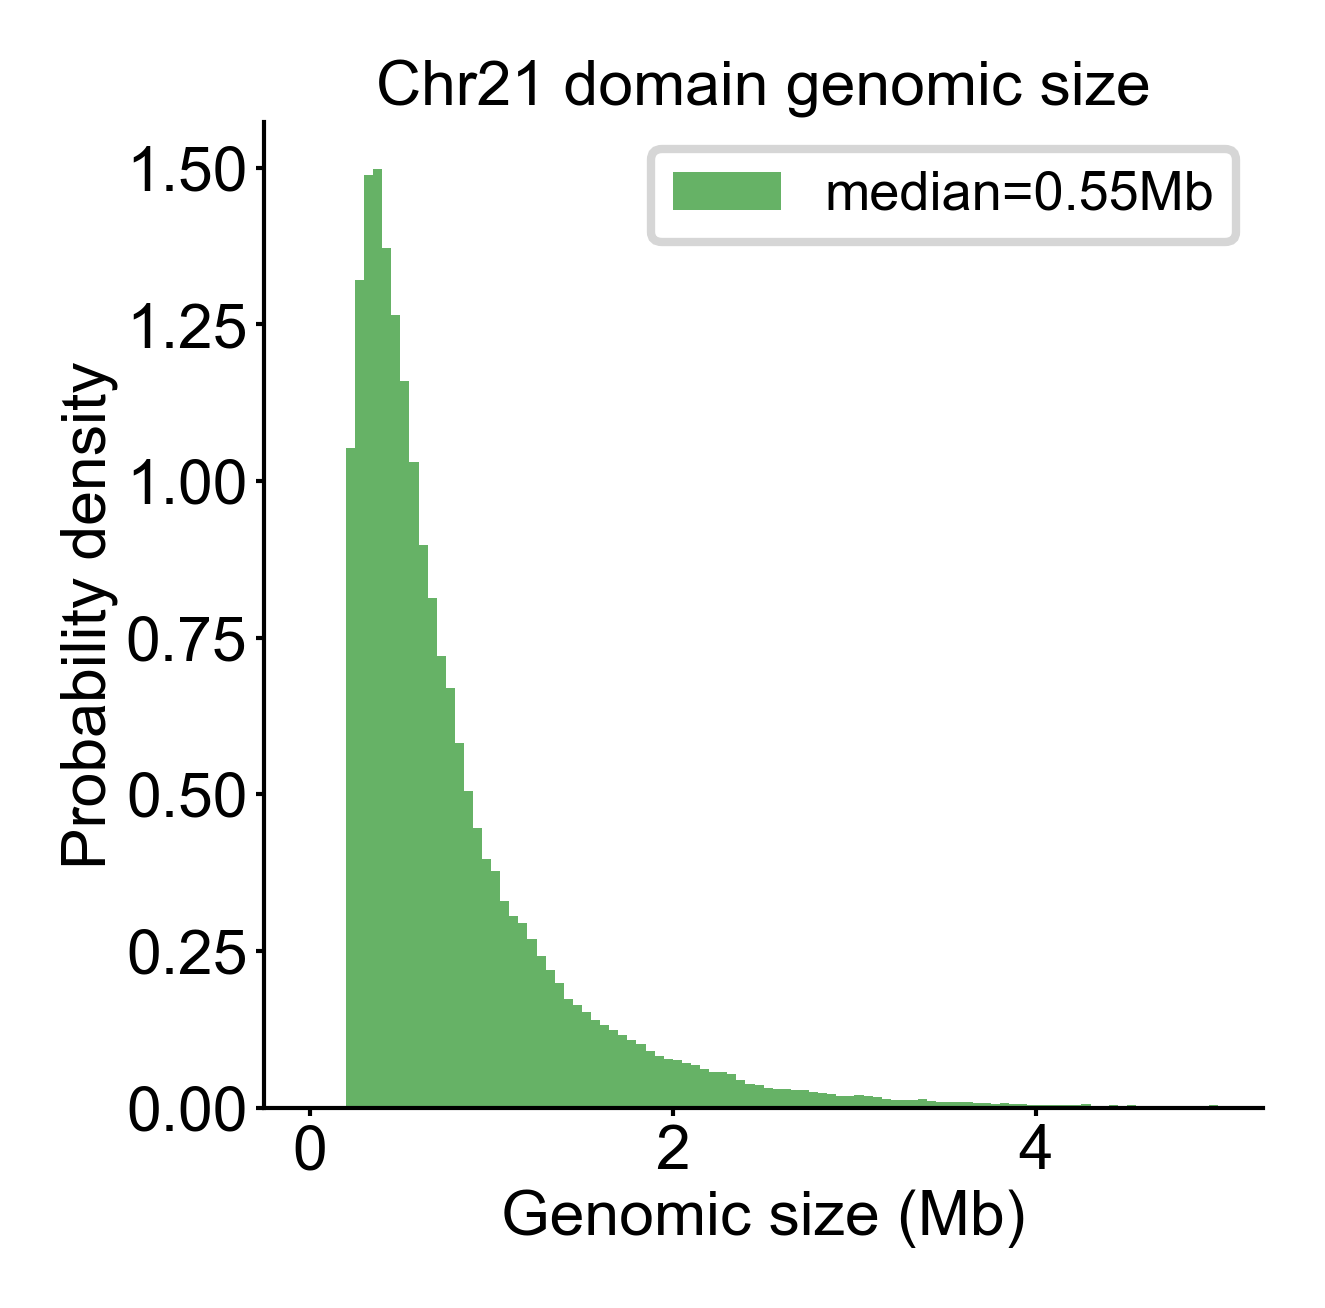

In [45]:
# genomic sizes
region_size = 0.05 # Mb
rep1_sz_list = []

for _zxys, _dm_starts in zip(data_rep1['dna_zxys'],data_rep1['domain_starts']):
    _starts = _dm_starts[:-1]
    _ends = _dm_starts[1:]
    # sizes
    _sizes = (_dm_starts[1:] - _dm_starts[:-1]) * region_size
    # append 
    rep1_sz_list.append(_sizes)

%matplotlib inline
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)
ax.hist(np.concatenate(rep1_sz_list), 100, range=(0,5), 
        density=True, color='g', alpha=0.6, label=f'median={np.nanmedian(np.concatenate(rep1_sz_list)):.2f}Mb')
ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(fontsize=_font_size-1)

ax.set_xlabel("Genomic size (Mb)", labelpad=1, fontsize=_font_size)
ax.set_ylabel("Probability density", labelpad=1, fontsize=_font_size)
ax.set_title("Chr21 domain genomic size", pad=2, fontsize=_font_size)

plt.gcf().subplots_adjust(bottom=0.15, left=0.16)

plt.savefig(os.path.join(figure_folder, f'Fig1I_chr21_domain_gsize_hist_rep1.pdf'), transparent=True)

plt.show()

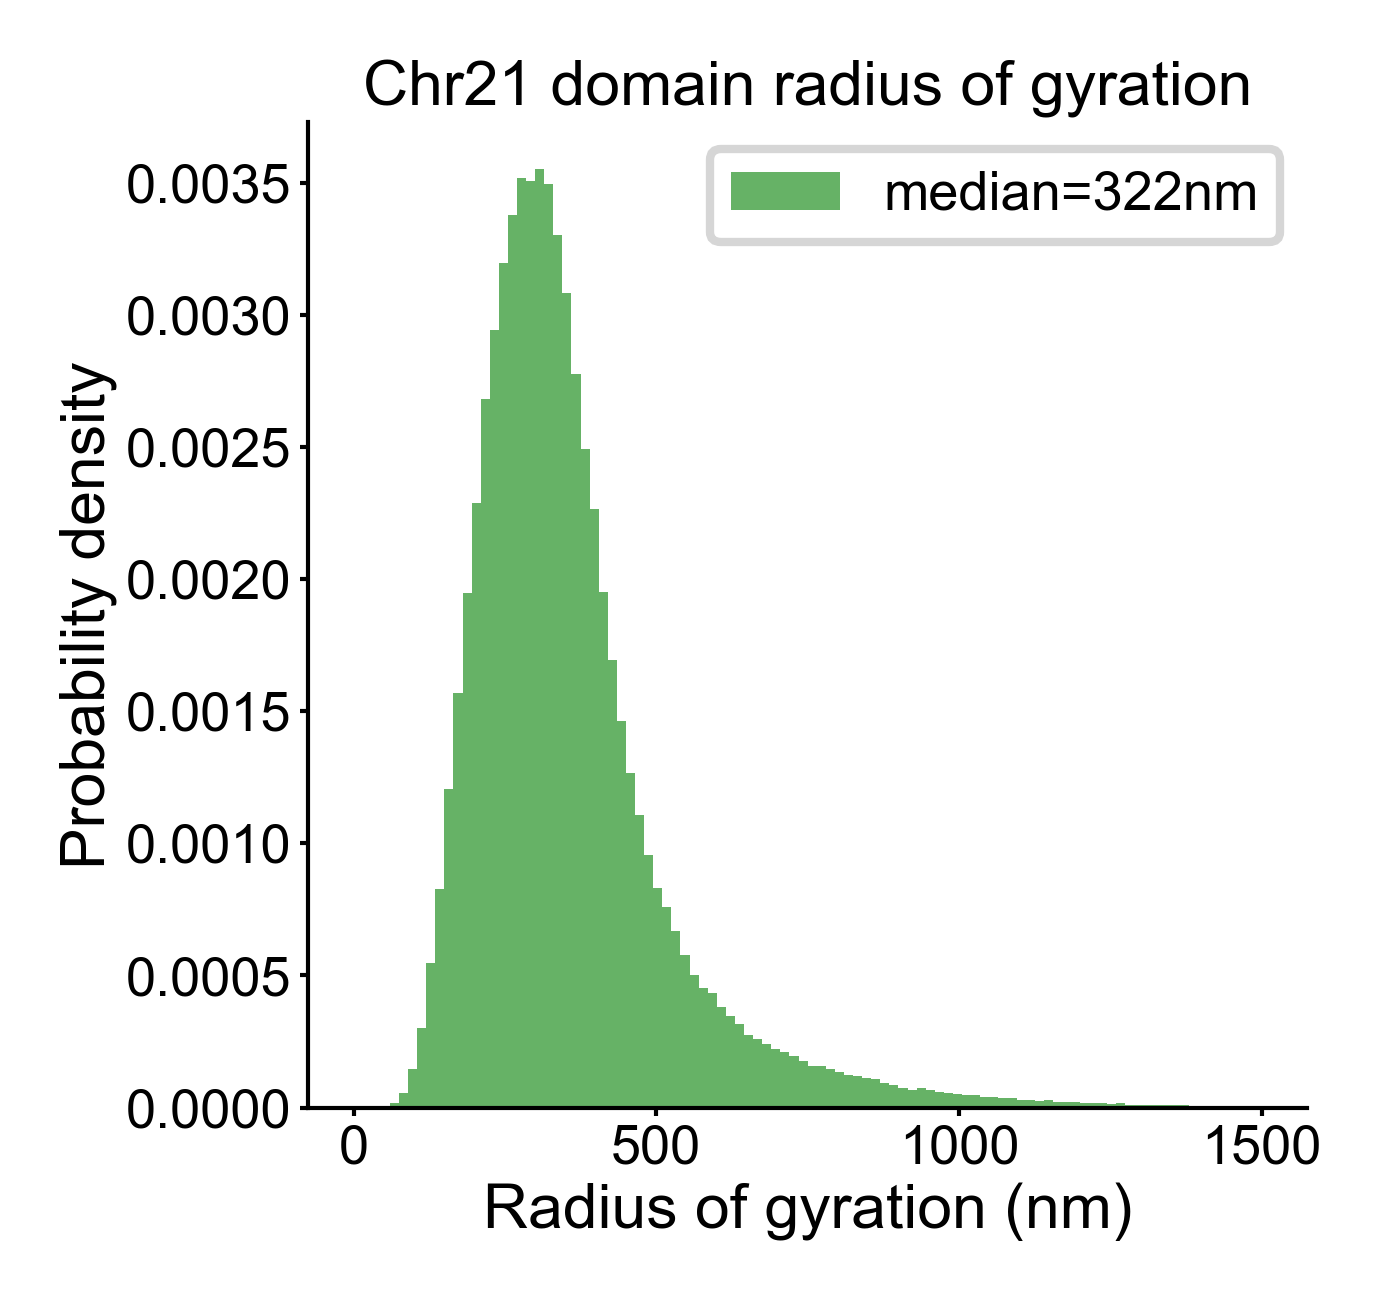

In [46]:
def rg_mean(zxy):
    """computes radius of gyration"""
    zxy_ = np.array(zxy)
    zxy_ = zxy_[~np.isnan(zxy_[:,0])]
    zxy_ = zxy_ - np.median(zxy_,0)
    return np.mean(np.linalg.norm(zxy_,axis=-1))

# radius of gyrations
rep1_rg_list = []

for _zxys, _dm_starts in zip(data_rep1['dna_zxys'],data_rep1['domain_starts']):
    _starts = _dm_starts[:-1]
    _ends = _dm_starts[1:]
    # rgs
    _rgs = np.array([rg_mean(_zxys[_s:_e]) for _s, _e in zip(_starts, _ends)])
    # append 
    rep1_rg_list.append(_rgs)


fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)
ax.hist(np.concatenate(rep1_rg_list), 100, range=(0,1500), 
        density=True, color='g', alpha=0.6, label=f'median={np.nanmedian(np.concatenate(rep1_rg_list)):.0f}nm')
ax.tick_params('both', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(fontsize=_font_size-1)

ax.set_xlabel("Radius of gyration (nm)", labelpad=1, fontsize=_font_size)
ax.set_ylabel("Probability density", labelpad=1, fontsize=_font_size)
ax.set_title("Chr21 domain radius of gyration", pad=2, fontsize=_font_size)

plt.gcf().subplots_adjust(bottom=0.15, left=0.16)

plt.savefig(os.path.join(figure_folder, f'Fig1J_chr21_domain_RG_hist_rep1.pdf'), transparent=True)
plt.show()

## 2.3 Single-cell boundary probability, insulation and alignment with CTCF/TADs

In [28]:
dom_starts_fs = data_rep1['domain_starts']
zxys = data_rep1['dna_zxys']
pts= zxys

### calculate boundary probability

In [31]:
dom_all = np.array([dom for doms in dom_starts_fs[::] for dom in doms[1:-1]])
unk_,cts_=np.unique(dom_all,return_counts=True)
cts = np.zeros(len(pts[0]))
cts[unk_]=cts_

### boundary probability for a zoom-in example

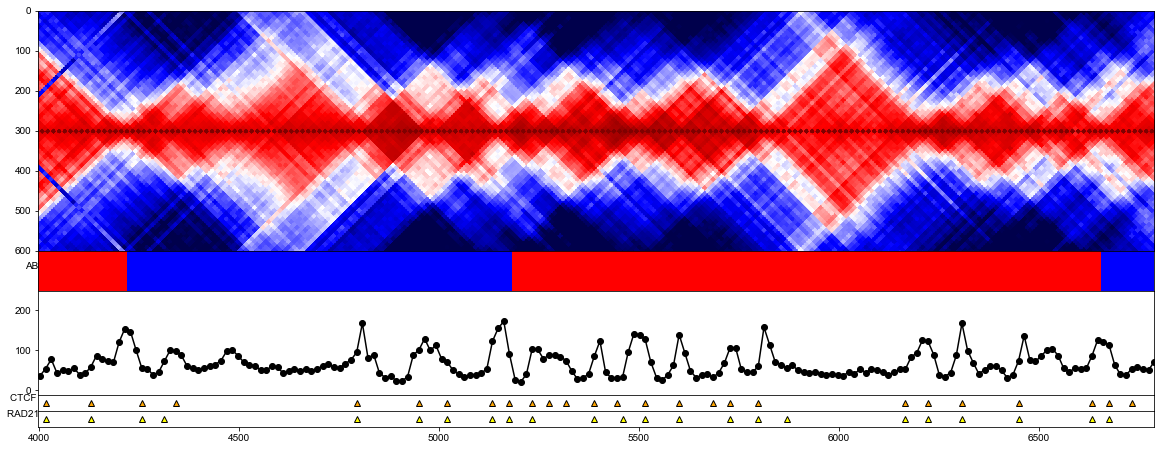

In [33]:
import matplotlib.pylab as plt
import numpy as np
import pickle,os
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist,cdist,squareform


####### You will need cv2. If you do not have it, run: pip install opencv-python
import cv2


from matplotlib import cm


def resize(im__,scale_percent = 100):
    width = int(im__.shape[1] * scale_percent / 100)
    height = int(im__.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(im__, dim, interpolation = cv2.INTER_NEAREST)
    return resized

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH),cv2.INTER_NEAREST)


def interp1dnan(A):
    A_=np.array(A)
    ok = np.isnan(A)==False
    xp = ok.nonzero()[0]
    fp = A[ok]
    x  = np.isnan(A).nonzero()[0]
    A_[np.isnan(A)] = np.interp(x, xp, fp)
    return A_

def interpolate_chr(_chr):
    """linear interpolate chromosome coordinates"""
    _new_chr = np.array(_chr)
    for i in range(_new_chr.shape[-1]):
        _new_chr[:,i]=interp1dnan(_new_chr[:,i])
    return _new_chr
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import cm
fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 1),axes_pad=0.)


mat_ = np.log(contact_map)
pad=0
min_val,max_val = -2,None   # the minimum and maximum distance in nanometers. this sets the threshold of the image
if max_val is None: max_val = np.nanmax(mat_)
if min_val is None: min_val = np.nanmin(mat_)
#This colors the image
im_ = (np.clip(mat_,min_val,max_val)-min_val)/(max_val-min_val)
im__ = np.array(cm.seismic(im_)[:,:,:3]*255,dtype=np.uint8)

# resize image 10x to get good resolution
resc = 10############
resized = resize(im__,resc*100)

# Rotate 45 degs
resized = rotate_bound(resized,-45)
start = int(pad*np.sqrt(2)*resc)
center = int(resized.shape[1]/2)

#Clip it to the desired size
padup=30##### how much of the matrix to keep in the up direction
resized = resized[center-resc*padup:center+resc*padup]



#List of positions of CTCF and rad21 in chr21
#ctcf 
ctcf = [  9,  21,  33,  67,  73,  78, 139, 226, 231, 235, 242, 253, 256,
       273, 284, 292, 301, 307, 339, 350, 355, 363, 366, 370, 373, 376,
       381, 385, 390, 396, 402, 405, 410, 436, 440, 446, 456, 469, 472,
       476, 482, 485, 488, 492, 500, 505, 508, 512, 520, 540, 543, 550,
       554, 560, 565, 576, 580, 585, 589, 592, 595, 599, 602, 606, 615,
       619, 622, 625, 628, 633, 636, 639]
# rad21
rad21=[ 21,  33,  67,  73, 139, 226, 231, 236, 242, 256, 273, 284, 292,
       301, 305, 339, 350, 355, 363, 366, 370, 381, 386, 390, 396, 405,
       410, 415, 436, 440, 446, 456, 469, 472, 482, 485, 492, 500, 505,
       508, 512, 543, 550, 554, 560, 576, 581, 585, 589, 593, 596, 599,
       602, 615, 619, 622, 625, 628, 633, 636]
A = [255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 494, 495, 496, 497, 498, 499, 500, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650]
A_=np.zeros([len(cts),100])
A_[A,:]=1
A_ = A_[np.linspace(0,len(A_)-1,resized.shape[1]).astype(int)]

start = 0
min__ = 0
cts_perc = 1.*cts/len(pts)*100*resc
x_vals = (np.arange(len(cts_perc))-min__)*resc*np.sqrt(2)-start
### plot the tads as vertical gray line
#bds_avg_ = (np.array(bds_avg)-min__)*resc*np.sqrt(2)-start
#for ele in bds_avg_:
#    grid[2].plot([ele,ele],[0,np.max(cts_perc)],color='gray')


grid[1].imshow(A_.T,cmap='bwr')
grid[2].plot(x_vals,cts_perc,'ko-')
grid[0].imshow(resized)
grid[3].plot(x_vals[ctcf],[0]*len(ctcf),'^',color='orange',mec='k')
grid[4].plot(x_vals[rad21],[0]*len(rad21),'^',color='yellow',mec='k')
ypad=20
grid[3].set_ylim([-ypad,ypad])
grid[4].set_ylim([-ypad,ypad])
grid[3].set_yticks([])
grid[4].set_yticks([])
grid[1].set_yticks([])
grid[1].set_ylabel('AB  ',rotation='horizontal')
grid[3].set_ylabel('CTCF        ',rotation='horizontal')
grid[4].set_ylabel('RAD21        ',rotation='horizontal')
min_,max_ = (282.69965127943635, 480)
grid[0].set_xlim([min_*resc*np.sqrt(2),max_*resc*np.sqrt(2)])

#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
#fig.savefig(folder_+r'Fig1C_lower.pdf')
plt.savefig(os.path.join(figure_folder, 
                         f'Fig1C_chr21_sc-domain_prob_rep1.pdf'), transparent=True)
plt.show()

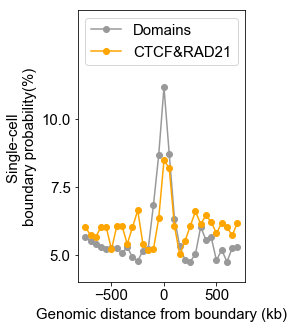

In [34]:
#List of positions of CTCF and rad21 in chr21
#ctcf 
ctcf = [  9,  21,  33,  67,  73,  78, 139, 226, 231, 235, 242, 253, 256,
       273, 284, 292, 301, 307, 339, 350, 355, 363, 366, 370, 373, 376,
       381, 385, 390, 396, 402, 405, 410, 436, 440, 446, 456, 469, 472,
       476, 482, 485, 488, 492, 500, 505, 508, 512, 520, 540, 543, 550,
       554, 560, 565, 576, 580, 585, 589, 592, 595, 599, 602, 606, 615,
       619, 622, 625, 628, 633, 636, 639]
# rad21
rad21=[ 21,  33,  67,  73, 139, 226, 231, 236, 242, 256, 273, 284, 292,
       301, 305, 339, 350, 355, 363, 366, 370, 381, 386, 390, 396, 405,
       410, 415, 436, 440, 446, 456, 469, 472, 482, 485, 492, 500, 505,
       508, 512, 543, 550, 554, 560, 576, 581, 585, 589, 593, 596, 599,
       602, 615, 619, 622, 625, 628, 633, 636]

A = [255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 494, 495, 496, 497, 498, 499, 500, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650]
A_ = np.zeros(len(zxys[0])+2)
A_[np.array(A)+1]=1
AB_bds = np.abs(np.diff(A_))
AB_bds = np.where(AB_bds)[0]
pts = zxys
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size']=15
matplotlib.rcParams['font.family']='Arial'
fig = plt.figure(figsize=(3,5))
#from jun-han - 500nm
bds_avg_ = [20, 35, 52, 67, 80, 113, 139, 159, 179, 198, 213, 227, 254, 273, 298, 317, 340, 351, 365, 373, 388, 411, 439, 460, 471, 486, 507, 540, 550, 561, 575, 592, 604, 613, 627, 636, 644]
dmat = np.abs(np.array([[bd2-bd1 for bd1 in bds_avg_] for bd2 in np.arange(len(pts[0]))],dtype=int))
dmat = np.array([[bd2-bd1 for bd1 in bds_avg_] for bd2 in np.arange(len(pts[0]))],dtype=int)
range_ = range(-15,15)
yvec = np.array([np.median(cts[np.where(dmat==i)[0]]) for i in range_])
plt.plot(np.array(range_)*50,yvec/len(pts)*100,'o-',color=[0.6]*3,label='Domains')
dmat = np.abs(np.array([[bd2-bd1 for bd1 in AB_bds] for bd2 in np.arange(len(pts[0]))],dtype=int))
dmat = np.array([[bd2-bd1 for bd1 in AB_bds] for bd2 in np.arange(len(pts[0]))],dtype=int)
yvec = np.array([np.median(cts[np.where(dmat==i)[0]]) for i in range_])
#plt.plot(np.array(range_)*50,yvec/len(pts)*100,'ko-',label='A/B compartments')
ctcf_rad21 = np.intersect1d(rad21,ctcf)
dmat = np.array([[bd2-bd1 for bd1 in ctcf_rad21] for bd2 in np.arange(len(pts[0]))],dtype=int)
yvec = np.array([np.median(cts[np.where(dmat==i)[0]]) for i in range_])
plt.plot(np.array(range_)*50,yvec/len(pts)*100,'o-',color='orange',label='CTCF&RAD21')

plt.yticks([5,7.5,10])
plt.ylim([4,14])
plt.xlabel('Genomic distance from boundary (kb)')
plt.ylabel('Single-cell \nboundary probability(%)')
plt.legend()
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
plt.savefig(os.path.join(figure_folder, 
                         f'Fig1D_chr21_sc-domain_prob_ctcf_rep1.pdf'), transparent=True)
plt.show()

### insulation scores w/wo ctcf

In [36]:
ichr=0
ins = []
A = [255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 494, 495, 496, 497, 498, 499, 500, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650]
A_ = np.zeros(len(zxys[0]))
A_[np.array(A)]=1
pur=[]
bdr_ins = []

dom_starts_fs = data_rep1['domain_starts']
zxys = data_rep1['dna_zxys']
for dom_ in tqdm(dom_starts_fs):
    zxy_ = zxys[ichr]
    for idom in range(1,len(dom_)-3):
        a,b,c = dom_[idom],dom_[idom+1],dom_[idom+2]
        #a,b,c = dom_[idom+1]-5,dom_[idom+1],dom_[idom+1]+5
        zxy1 = zxy_[a:b]
        zxy2 = zxy_[b:c]
        
        med_in = np.nanmedian(np.concatenate([pdist(zxy1),pdist(zxy2)]))
        med_out = np.nanmedian(cdist(zxy1,zxy2))
        ins_ = med_out/med_in
        ins.append(ins_)
        pur.append(np.mean(A_[a:c]))
        bdr_ins.append(b)
    ichr+=1    
    
pur=np.array(pur)
bdr_ins=np.array(bdr_ins)
ins = np.array(ins)

E:\Users\puzheng\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


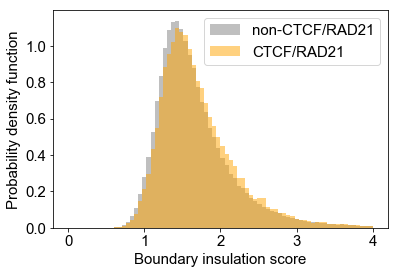

In [37]:
nonctcf = np.ones(len(zxys[0]))
nonctcf[ctcf_rad21]=0
nonctcf = np.nonzero(nonctcf)[0]

fig = plt.figure()#figsize=(10,7))
bins=np.linspace(0,4,75)
#plt.hist(ins[pur==1],alpha=0.5,normed=True,bins=bins,color='r',label = 'within A')
#plt.hist(ins[pur==0],alpha=0.5,normed=True,bins=bins,color='b',label = 'within B')
plt.hist(ins[np.in1d(bdr_ins,nonctcf)],alpha=0.5,normed=True,bins=bins,color='gray',label = 'non-CTCF/RAD21')
plt.hist(ins[np.in1d(bdr_ins,ctcf_rad21)],alpha=0.5,normed=True,bins=bins,color='orange',label = 'CTCF/RAD21')
plt.xlabel('Boundary insulation score')
plt.ylabel('Probability density function')
plt.legend()
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
plt.savefig(os.path.join(figure_folder, 
                         f'Fig1K_chr21_sc-domain_insulation_ctcf_rep1.pdf'), transparent=True)
plt.show()

## 2.5 CTCF end-end distance and radii of gyration of CTCF bound domains

In [38]:
from tqdm import tqdm_notebook as tqdm
dic_ctcf = {}
dic_nonctcf = {}

def rg_med(zxy):
    """computes radius of gyration"""
    zxy_ = np.array(zxy)
    zxy_ = zxy_[~np.isnan(zxy_[:,0])]
    zxy_ = zxy_ - np.median(zxy_,0)
    return np.mean(np.linalg.norm(zxy_,axis=-1))

def inD(zxy): 
    """computest mean interdistance"""
    return np.nanmean(pdist(zxy))

dic_rgctcf = {}
dic_rgnonctcf = {}

dic_inDctcf = {}
dic_inDnonctcf = {}

dic_withinDctcf = {}
dic_withinDnonctcf = {}
###################### This does not save each ctcf pair in its own key but already groups by genomic distance
ctcf_or_rad21 = np.union1d(ctcf,rad21)
for ichr in tqdm(range(len(zxys))):
    doms=dom_starts_fs[ichr][1:-1]
    zxy = zxys[ichr]
    for i in range(len(doms)-1):
        e1,e2 = doms[i],doms[i+1]-1
        dist_ = np.linalg.norm(zxy[e1]-zxy[e2])
        gen_dist = e2-e1
        rg_ = rg_med(zxy[e1:e2])
        inD_ = inD(zxy[e1:e2])
        if (e1 in ctcf_or_rad21) and (e2 in ctcf_or_rad21):
            dic_ctcf[gen_dist]=dic_ctcf.get(gen_dist,[])+[dist_]
            dic_rgctcf[gen_dist]=dic_rgctcf.get(gen_dist,[])+[rg_]
            dic_inDctcf[gen_dist]=dic_inDctcf.get(gen_dist,[])+[inD_]
        if not np.any(np.in1d([e1,e1+1,e1-1,e2,e2+1,e2-1],ctcf_or_rad21)):
        #if not np.any(np.in1d([e1,e2],ctcf_or_rad21)):
            dic_nonctcf[gen_dist]=dic_nonctcf.get(gen_dist,[])+[dist_]
            dic_rgnonctcf[gen_dist]=dic_rgnonctcf.get(gen_dist,[])+[rg_]

        e1p = np.random.randint(e1+1,e2-1)
        e2p = np.random.randint(e1p,e2-1)
        if not np.any(np.in1d([e1p,e1p+1,e1p-1,e2p,e2p+1,e2p-1],ctcf_or_rad21)):
            gen_dist__ = abs(e1p-e2p)
            dist__ = np.linalg.norm(zxy[e1p]-zxy[e2p])
            dic_withinDnonctcf[gen_dist__]=dic_withinDnonctcf.get(gen_dist__,[])+[dist__]
        for e1p in range(e1+1,e2-1):
            for e2p in range(e1p,e2-1):
                if (e1p in ctcf_or_rad21) and (e2p in ctcf_or_rad21):
                    gen_dist__ = abs(e1p-e2p)
                    dist__ = np.linalg.norm(zxy[e1p]-zxy[e2p])
                    dic_withinDctcf[gen_dist__]=dic_withinDctcf.get(gen_dist__,[])+[dist__]


In [106]:
pickle.dump([dic_ctcf,dic_nonctcf,dic_rgctcf,dic_rgnonctcf,dic_inDctcf,dic_inDnonctcf,dic_withinDctcf,dic_withinDnonctcf],
           open(r'C:\Users\Bogdan\Dropbox\Chromosome21_online\rg_and_edge-edge_distance_v2_repeat','wb'))

In [39]:
gen_dists = np.sort(list(dic_ctcf.keys()))
gen_dists = gen_dists[gen_dists<=28]
gen_dists = gen_dists[gen_dists>=4]
print([len(dic_nonctcf.get(gn,[])) for gn in gen_dists])

[8189, 8425, 8278, 6929, 5961, 5567, 4932, 4521, 3954, 3304, 2993, 2651, 2462, 2231, 2039, 1947, 1686, 1576, 1429, 1251, 1118, 1050, 996, 884, 813]


In [40]:
def boostrap_err2(x_,y_,func,N=1000,perc_min=5,perc_max=95):
    elems = []
    for istrap in range(N):
        x__ = np.random.choice(x_,[len(x_)])
        y__ = np.random.choice(y_,[len(y_)])
        elems.append(func(x__,y__))
    return (np.nanpercentile(elems,perc_min),np.nanpercentile(elems,perc_max))

gen_dists = np.sort(list(dic_ctcf.keys()))
gen_dists = gen_dists[gen_dists<=28]
gen_dists = gen_dists[gen_dists>=4]
def func(x,y): return np.nanmedian(x)/np.nanmedian(y)
xelems = gen_dists*50
meds_ctcf = [func(dic_ctcf.get(gn,[]),dic_withinDctcf.get(gn,[])) for gn in gen_dists]
errs_ctcf = np.abs(np.array([boostrap_err2(dic_ctcf.get(gn,[]),dic_withinDctcf.get(gn,[]),func) 
                             for gn in tqdm(gen_dists)]).T-meds_ctcf)
xelems = gen_dists*50
meds_non = [func(dic_nonctcf.get(gn,[]),dic_withinDnonctcf.get(gn,[])) for gn in gen_dists]
errs_non = np.abs(np.array([boostrap_err2(dic_nonctcf.get(gn,[]),dic_withinDnonctcf.get(gn,[]),func) 
                             for gn in tqdm(gen_dists)]).T-meds_non)

Text(0.5, 0, 'Genomic distance (kb)')

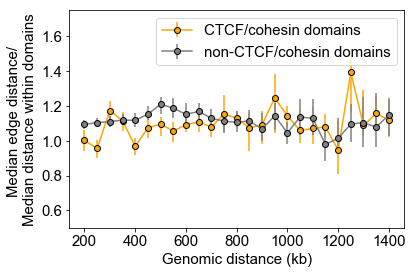

In [42]:
fig = plt.figure()
xelems = gen_dists*50
plt.errorbar(xelems,meds_ctcf,
             yerr=errs_ctcf,
             color='orange',mec='k',label='CTCF/cohesin domains',marker='o')

plt.errorbar(xelems,meds_non,
             yerr=errs_non,
             color='gray',mec='k',label='non-CTCF/cohesin domains',marker='o')
plt.legend()
plt.ylim([0.5,1.75])
plt.ylabel('Median edge distance/ \nMedian distance within domains')
plt.xlabel('Genomic distance (kb)')
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\FinalFigures\Figure 1\subpanels'
#fig.savefig(folder_+os.sep+r'Fig1L_new.pdf')

In [43]:
### Radius of gyration
def boostrap_err(x_,func,N=1000,perc_min=5,perc_max=95):
    elems = []
    for istrap in range(N):
        elems.append(func(np.random.choice(x_,[len(x_)])))
    return (np.nanpercentile(elems,perc_min),np.nanpercentile(elems,perc_max))

gen_dists = np.sort(list(dic_rgctcf.keys()))
gen_dists = gen_dists[gen_dists<=28]
gen_dists = gen_dists[gen_dists>=4]


func = np.nanmedian

xelems = gen_dists*50
meds_ctcf_rg = [func(dic_rgctcf[gn]) for gn in gen_dists]
errs_ctcf_rg = np.abs(np.array([boostrap_err(dic_rgctcf[gn],func) for gn in gen_dists]).T-meds_ctcf_rg)
xelems = gen_dists*50
meds_non_rg = [func(dic_rgnonctcf[gn]) for gn in gen_dists]
errs_non_rg = np.abs(np.array([boostrap_err(dic_rgnonctcf[gn],func) for gn in gen_dists]).T-meds_non_rg)

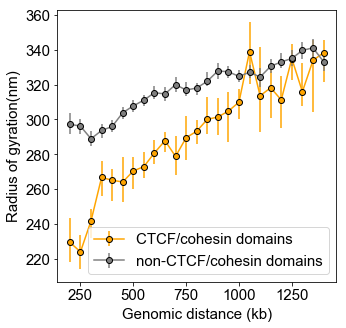

In [44]:
fig = plt.figure(figsize=(5,5))#figsize=(8,3))

plt.errorbar(xelems,meds_ctcf_rg,
             yerr=errs_ctcf_rg,
             color='orange',mec='k',label='CTCF/cohesin domains',marker='o')

plt.errorbar(xelems,meds_non_rg,
             yerr=errs_non_rg,
             color='gray',mec='k',label='non-CTCF/cohesin domains',marker='o')
plt.ylabel('Radius of gyration(nm)')
plt.xlabel('Genomic distance (kb)')
plt.legend()
#folder = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\FinalFigures\Figure S1\Sub-panels-newAnalysis'
#fig.savefig(folder+os.sep+'rg_ctcf_rgular.pdf')

### Radius of gyration vs genomic distance

In [117]:
dom_starts_fs = data_rep1['domain_starts']
zxys = data_rep1['dna_hzxys'][:,:,1:]
pts=zxys

In [118]:
def rg_med(zxy):
    """computes radius of gyration"""
    zxy_ = np.array(zxy)
    zxy_ = zxy_[~np.isnan(zxy_[:,0])]
    zxy_ = zxy_ - np.median(zxy_,0)
    return np.mean(np.linalg.norm(zxy_,axis=-1))

dic_rg = {}
for ichr in tqdm(range(len(pts))):
    doms=dom_starts_fs[ichr][1:-1]
    zxy = pts[ichr]
    for i in range(len(doms)-1):
        e1,e2 = doms[i],doms[i+1]-1
        start = e1
        end=e2#-1
        rg_ = rg_med(zxy[start:end])
        key = end-start
        dic_rg[key] = dic_rg.get(key,[])+[rg_]

In [76]:
fig = plt.figure(figsize=(10,5))
keys = np.sort(list(dic_rg.keys()))
keys = keys[keys>=5]
plt.boxplot([dic_rg[gn] for gn in keys][:100], notch=True, showfliers=False,whis = [10, 90]);
xlab = np.arange(6)
plt.xticks(xlab*1000/50,xlab);
plt.ylabel('Radius of gyration (nm)')
plt.xlabel('Genomic size of single-cell domains (Mb)')
#save_folder = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\base_images\TAD_sizes'
#fig.savefig(save_folder+os.sep+'domain_Rgs_gensize_v2.pdf')

NameError: name 'dic_rg' is not defined

<Figure size 720x360 with 0 Axes>

### check repeat

In [80]:
dom_starts_fs = data_rep2['domain_starts']
zxys = data_rep2['dna_hzxys'][:,:,1:]
pts=zxys

In [83]:
from tqdm import tqdm_notebook as tqdm
def rg_med(zxy):
    """computes radius of gyration"""
    zxy_ = np.array(zxy)
    zxy_ = zxy_[~np.isnan(zxy_[:,0])]
    zxy_ = zxy_ - np.median(zxy_,0)
    return np.mean(np.linalg.norm(zxy_,axis=-1))

dic_rg = {}
for ichr in tqdm(range(len(pts))):
    doms=dom_starts_fs[ichr][1:-1]
    zxy = pts[ichr]
    for i in range(len(doms)-1):
        e1,e2 = doms[i],doms[i+1]-1
        start = e1
        end=e2#-1
        rg_ = rg_med(zxy[start:end])
        key = end-start
        dic_rg[key] = dic_rg.get(key,[])+[rg_]

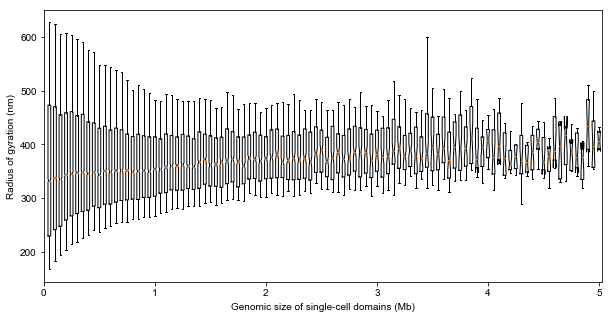

In [84]:
fig = plt.figure(figsize=(10,5))
keys = np.sort(list(dic_rg.keys()))
keys = keys[keys>=5]
plt.boxplot([dic_rg[gn] for gn in keys][:100], notch=True, showfliers=False,whis = [10, 90]);
xlab = np.arange(6)
plt.xticks(xlab*1000/50,xlab);
plt.ylabel('Radius of gyration (nm)')
plt.xlabel('Genomic size of single-cell domains (Mb)')
save_folder = r'V:\Chromatin_Share\final_figures\Chr21_domain_figures'
fig.savefig(save_folder+os.sep+'FigS1N_domain_Rgs_gensize_v2.pdf')

In [ ]:
# Analysis for repeat


## Letter figure 5: characterization domain and compartment in G1/G2-S cells

## Load data rep2

In [9]:
# load from file and extract info
import csv
rep2_info_dict = {}
with open(rep2_filename, 'r') as _handle:
    _reader = csv.reader(_handle, delimiter='\t', quotechar='|')
    _headers = next(_reader)
    print(_headers)
    # create keys for each header
    for _h in _headers:
        rep2_info_dict[_h] = []
    # loop through content
    for _contents in _reader:
        for _h, _info in zip(_headers,_contents):
            rep2_info_dict[_h].append(_info)

['Z(nm)', 'X(nm)', 'Y(nm)', 'Genomic coordinate', 'Chromosome copy number', 'Gene names', 'Transcription', 'TSS ZXY(nm)', 'Cell cycle state']


In [10]:
from tqdm import tqdm_notebook as tqdm

# clean up infoa
data_rep2 = {'params':{}}

# clean up genomic coordiantes
region_names = np.array([_n for _n in sorted(region_names, key=lambda s:int(s.split(':')[1].split('-')[0]))])
region_starts = np.array([int(_n.split(':')[1].split('-')[0]) for _n in region_names])
region_ends = np.array([int(_n.split(':')[1].split('-')[1]) for _n in region_names])[np.argsort(region_starts)]
region_starts = np.sort(region_starts)

mid_positions = ((region_starts + region_ends)/2).astype(np.int)
mid_positions_Mb = np.round(mid_positions / 1e6, 2) 

# clean up chrom copy number
chr_nums = np.array([int(_info) for _info in rep2_info_dict['Chromosome copy number']])
chr_ids, region_cts = np.unique(chr_nums, return_counts=True)
dna_zxys_list = [[[] for _start in region_starts] for _id in chr_ids]

# clean up zxy
for _z,_x,_y,_reg_info, _cid in tqdm(zip(rep2_info_dict['Z(nm)'],rep2_info_dict['X(nm)'],\
                                         rep2_info_dict['Y(nm)'],rep2_info_dict['Genomic coordinate'],\
                                         rep2_info_dict['Chromosome copy number'])):
    # get chromosome inds
    _cid = int(_cid)
    _cind = np.where(chr_ids == _cid)[0][0]
    
    # get region indices
    _start = int(_reg_info.split(':')[1].split('-')[0])
    _rind = np.where(region_starts==_start)[0][0]
    
    dna_zxys_list[_cind][_rind] = np.array([float(_z),float(_x), float(_y)])

# merge together
dna_zxys_list = np.array(dna_zxys_list)
data_rep2['chrom_ids'] = chr_ids
data_rep2['region_names'] = region_names
data_rep2['mid_position_Mb'] = mid_positions_Mb
data_rep2['dna_zxys'] = dna_zxys_list

# clean up tss and transcription
if 'Gene names' in rep2_info_dict:
    import re
    # first extract number of genes
    gene_names = []
    for _gene_info, _trans_info, _tss_coord in zip(rep2_info_dict['Gene names'],
                                                   rep2_info_dict['Transcription'],
                                                   rep2_info_dict['TSS ZXY(nm)']):
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            for _gene in _genes:
                if _gene not in gene_names:
                    gene_names.append(_gene)
    print(f"{len(gene_names)} genes exist in this dataset.")
    
    # initialize gene and transcription
    tss_zxys_list = [[[] for _gene in gene_names] for _id in chr_ids]
    transcription_profiles = [[[] for _gene in gene_names] for _id in chr_ids]
    # loop through to get info
    for _cid, _gene_info, _trans_info, _tss_locations in tqdm(zip(rep2_info_dict['Chromosome copy number'],
                                                                  rep2_info_dict['Gene names'],
                                                                  rep2_info_dict['Transcription'],
                                                                  rep2_info_dict['TSS ZXY(nm)'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        # process if there are genes in this region:
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            _transcribes = _trans_info.split(';')[:-1]
            _tss_zxys = _tss_locations.split(';')[:-1]
            for _gene, _transcribe, _tss_zxy in zip(_genes, _transcribes, _tss_zxys):
                # get gene index
                _gind = gene_names.index(_gene)
                # get transcription profile
                if _transcribe == 'on':
                    transcription_profiles[_cind][_gind] = True
                else:
                    transcription_profiles[_cind][_gind] = False
                # get coordinates
                _tss_zxy = np.array([np.float(_c) for _c in re.split(r'\s+', _tss_zxy.split('[')[1].split(']')[0]) if _c != ''])
                tss_zxys_list[_cind][_gind] = _tss_zxy
                
    tss_zxys_list = np.array(tss_zxys_list)
    transcription_profiles = np.array(transcription_profiles)
    data_rep2['gene_names'] = gene_names
    data_rep2['tss_zxys'] = tss_zxys_list
    data_rep2['trans_pfs'] = transcription_profiles

# clean up cell_cycle states
if 'Cell cycle state' in rep2_info_dict:
    cell_cycle_types = np.unique(rep2_info_dict['Cell cycle state'])
    cell_cycle_flag_dict = {_k:[[] for _id in chr_ids] for _k in cell_cycle_types if _k != 'ND'}
    for _cid, _state in tqdm(zip(rep2_info_dict['Chromosome copy number'],rep2_info_dict['Cell cycle state'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        if np.array([_v[_cind]==[] for _k,_v in cell_cycle_flag_dict.items()]).any():
            for _k,_v in cell_cycle_flag_dict.items():
                if _k == _state:
                    _v[_cind] = True
                else:
                    _v[_cind] = False
    # append to data
    for _k, _v in cell_cycle_flag_dict.items():
        data_rep2[f'{_k}_flags'] = np.array(_v)  


84 genes exist in this dataset.


## call domains for rep2

In [13]:
import source.domain_tools.DomainAnalysis as da
import multiprocessing as mp

num_threads=32
domain_corr_cutoff = 0.75 
domain_dist_cutoff = 500 # nm

_domain_args = [(_zxys, 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _zxys in data_rep2['dna_zxys']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
if 'domain_starts' not in data_rep2:
    with mp.Pool(num_threads) as domain_pool:
        domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
        domain_pool.close()
        domain_pool.join()
        domain_pool.terminate()
    # save
    data_rep2['domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
    data_rep2['params']['domain_corr_cutoff'] = domain_corr_cutoff
    data_rep2['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts in 60.080s.


In [14]:
from tqdm import tqdm_notebook as tqdm

def rg_mean(zxy):
    """computes radius of gyration"""
    zxy_ = np.array(zxy)
    zxy_ = zxy_[~np.isnan(zxy_[:,0])]
    zxy_ = zxy_ - np.mean(zxy_,0)
    return np.sqrt(np.mean(np.sum(zxy_**2,axis=-1)))

g1_rgs = []
g2_rgs = []

for _i, (pt_,doms_) in tqdm(enumerate(zip(data_rep2['dna_zxys'],data_rep2['domain_starts']))):
    for i1,i2 in zip(doms_[1:-2],doms_[2:-1]):
        if data_rep2['G1_flags'][_i]:
            g1_rgs.append(rg_mean(pt_[i1:i2]))
        elif data_rep2['G2/S_flags'][_i]:
            g2_rgs.append(rg_mean(pt_[i1:i2]))
g1_rgs = np.array(g1_rgs)
g2_rgs = np.array(g2_rgs)


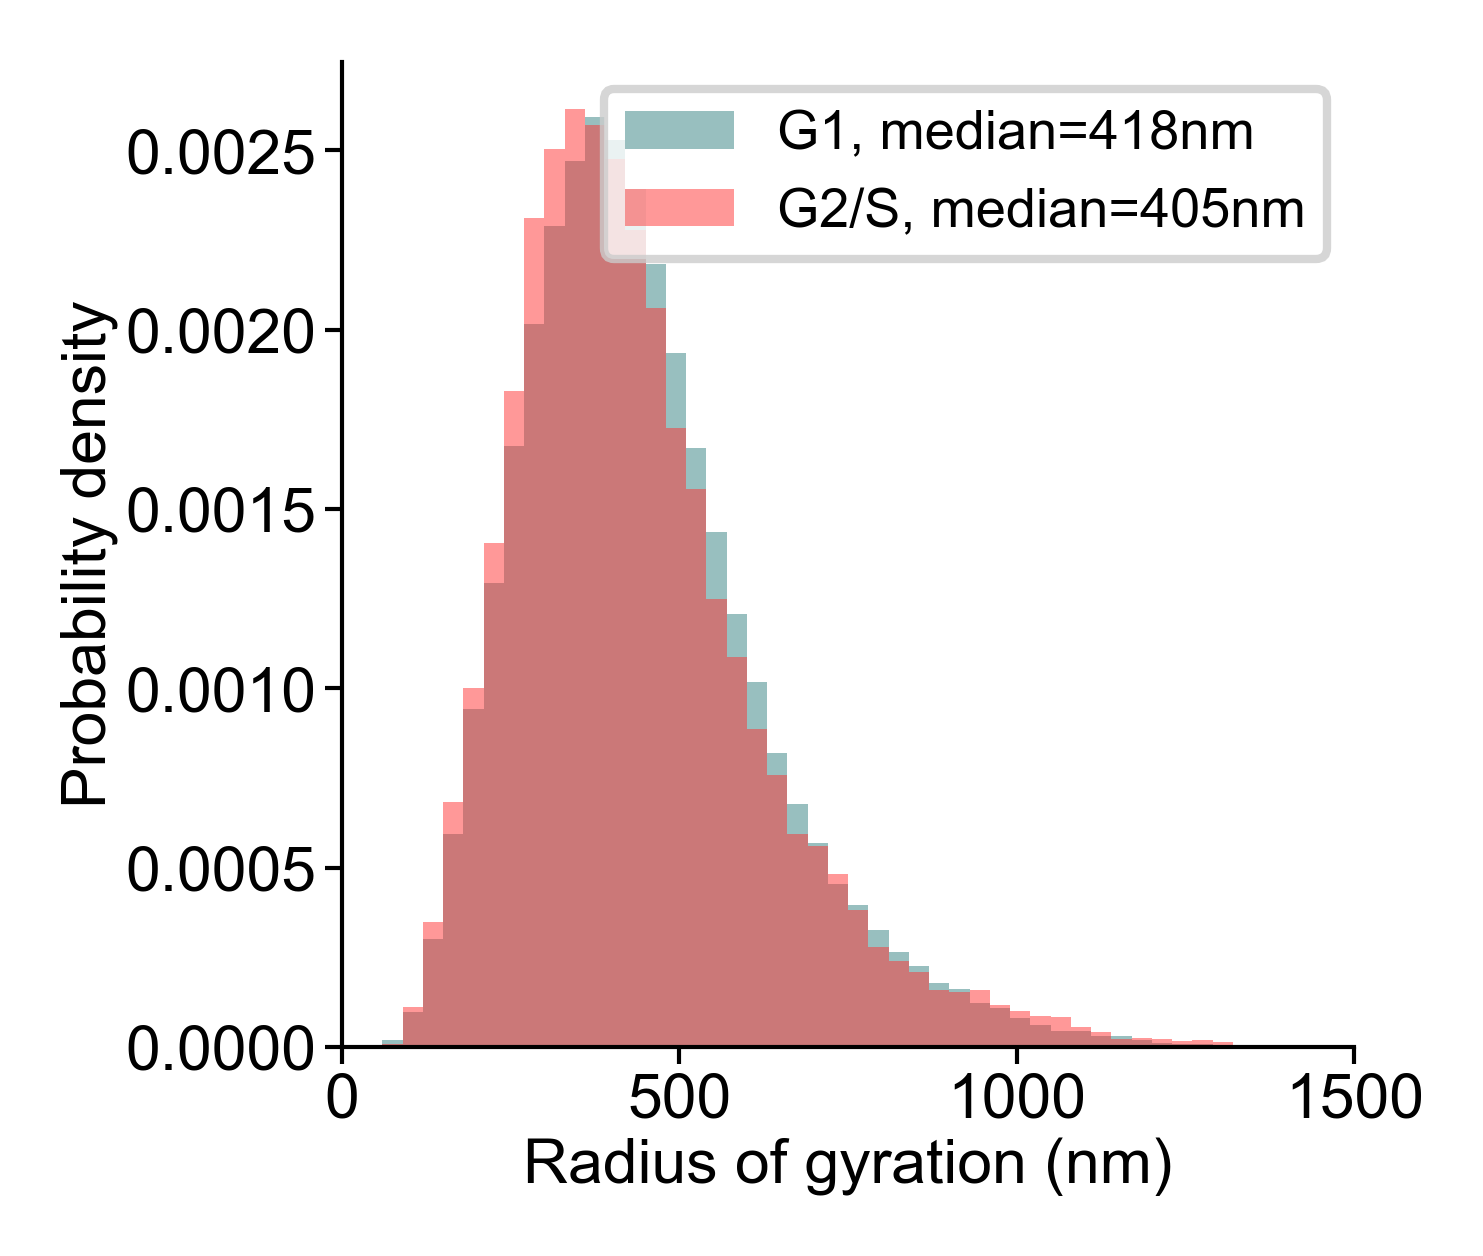

In [15]:
%matplotlib inline

rg_limits = [0,1500]

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

ax.hist(g1_rgs, 50, range=(min(rg_limits),max(rg_limits)),
        density=True, alpha=0.5, 
        color=[0.2,0.5,0.5], label=f'G1, median={np.nanmedian(g1_rgs):.0f}nm')
ax.hist(g2_rgs, 50, range=(min(rg_limits),max(rg_limits)),
        density=True, alpha=0.5, 
        color=[1,0.2,0.2], label=f'G2/S, median={np.nanmedian(g2_rgs):.0f}nm')

ax.legend(fontsize=_font_size-1, loc='upper right')

ax.set_xlabel("Radius of gyration (nm)", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(rg_limits)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)

plt.savefig(os.path.join(figure_folder, f'LFig5A_chr21-repeat_radius_of_gyration_G1-G2.pdf'), transparent=True)

plt.show()

In [18]:
from tqdm import tqdm_notebook as tqdm

resolution = 0.05 # Mb

g1_gsizes = []
g2_gsizes = []

for _i, (pt_,doms_) in tqdm(enumerate(zip(data_rep2['dna_zxys'],data_rep2['domain_starts']))):
    for i1,i2 in zip(doms_[1:-2],doms_[2:-1]):
        if data_rep2['G1_flags'][_i]:
            g1_gsizes.append((i2-i1)*resolution)
        elif data_rep2['G2/S_flags'][_i]:
            g2_gsizes.append((i2-i1)*resolution)
g1_gsizes = np.array(g1_gsizes)
g2_gsizes = np.array(g2_gsizes)


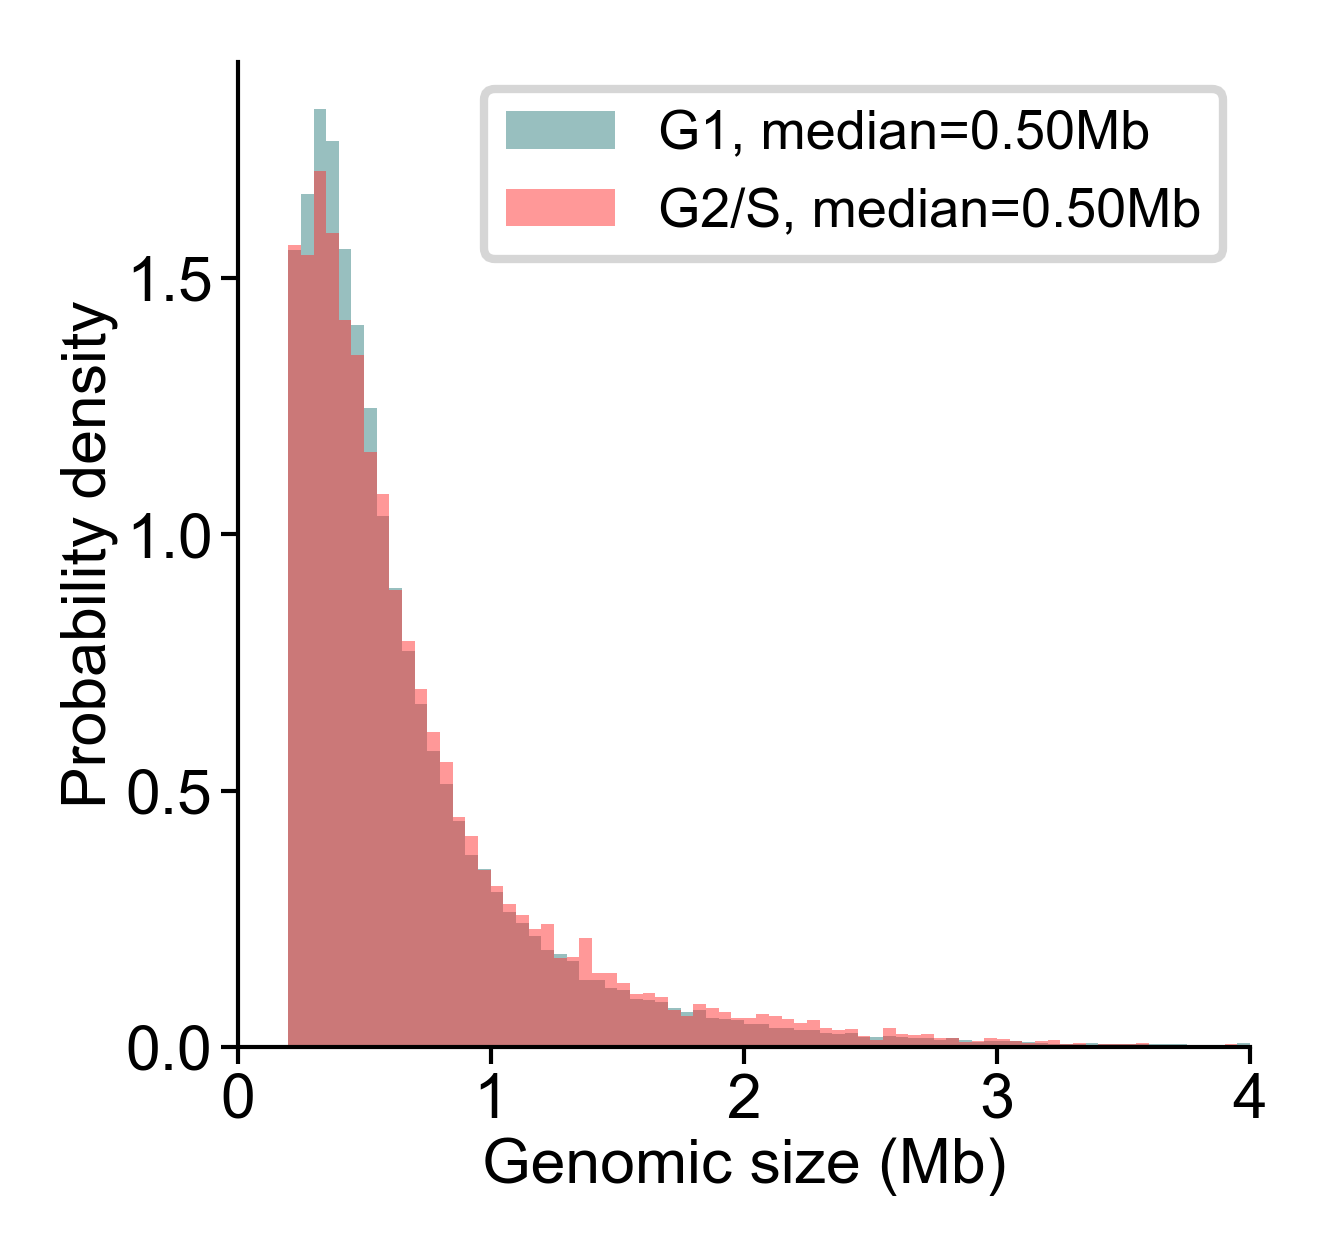

In [20]:
%matplotlib inline

rg_limits = [0,4]

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

ax.hist(g1_gsizes, 80, range=(min(rg_limits),max(rg_limits)),
        density=True, alpha=0.5, 
        color=[0.2,0.5,0.5], label=f'G1, median={np.nanmedian(g1_gsizes):.2f}Mb')
ax.hist(g2_gsizes, 80, range=(min(rg_limits),max(rg_limits)),
        density=True, alpha=0.5, 
        color=[1,0.2,0.2], label=f'G2/S, median={np.nanmedian(g2_gsizes):.2f}Mb')

ax.legend(fontsize=_font_size-1, loc='upper right')

ax.set_xlabel("Genomic size (Mb)", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(rg_limits)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)

plt.savefig(os.path.join(figure_folder, f'LFig5B_chr21-repeat_domain_size_G1-G2.pdf'), transparent=True)

plt.show()